# Necessary Dependencies

In [1]:
# ! pip install keras
# ! pip install tensorflow

# Load the Datasets

We will be looking at ETH data from March 1, 2017 to present. Ethereum has been around before March 1st, but this month was when the price of Ether took off and then had far more variation.

Data is taken from https://www.investing.com/currencies/eth-usd, https://www.kaggle.com/sudalairajkumar/cryptocurrencypricehistory/data, and https://etherscan.io/, and https://github.com/

## Load Ether Data

In [1]:
%matplotlib inline

import pandas as pd
import datetime as dt

ether_df = pd.read_csv(filepath_or_buffer='./data/ETH_DataSet.csv', sep=',')
ether_df['Date'] = pd.to_datetime(ether_df['Date'])
ether_df['Date'] = [time.date() for time in ether_df['Date']]
ether_df.head(n=5).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused
0,2017-12-18,785.99,984021,15048543,9.6364e+07,75741.1,147283,1783.75,5781,27932,14.67,27442929390,7996603,43186977264
1,2017-12-17,717.71,876574,14830225,9.63434e+07,69146.6,142954,1754.69,5781,25965,14.66,29121338315,7995227,41694276203
2,2017-12-16,699.09,899857,14626324,9.63231e+07,66735.5,141946,1740.33,5775,26389,14.58,35296363949,7996145,42279195527
3,2017-12-15,693.58,904346,14448281,9.63027e+07,65897.1,143758,1716.28,5800,26180,14.52,35432934113,7995378,42607604617
4,2017-12-14,692.83,942559,14252053,9.62819e+07,66779.2,137630,1641.3,5694,26049,14.82,41791954659,7995365,43964305213


## Load Github Commit History Data

The github commit history data is taken up to November. No more data was taken, since after performing feature selection, this feature was not a prominant predictor of the price.

In [2]:
from pprint import pprint
import json
import os
from dateutil.parser import parse

directory_path = './data/github'

def format_date(date):
    return parse(date).strftime('%Y-%m-%d').lstrip("0").replace(" 0", " ")

def remove_time_from_commit(date):
    indexOfTimeStart = date.find('T')
    return date[0:indexOfTimeStart]

def get_commit_dict(directory_path):
    commit_dict = {};
    files = [f for f in os.scandir(directory_path) if os.path.isfile(f)]
    for f in files:
        with open(f) as data:    
            commit_history = json.load(data)
            nodes = commit_history['data']['repository']['ref']['target']['history']['edges']
            for node in nodes:
                date = format_date(remove_time_from_commit(node['node']['author']['date']))
                if date in commit_dict :
                    commit_dict[date] += 1
                else:
                    commit_dict[date] = 1
        return commit_dict
    
commit_dict = get_commit_dict(directory_path)

github_df = pd.DataFrame(list(commit_dict.items()), columns=['Date', 'Number_Commits'])
github_df['Date'] = pd.to_datetime(github_df['Date'])
github_df['Date'] = [time.date() for time in github_df['Date']]
github_df.head(n=5).style

,Date,Number_Commits
0,2017-11-02,2
1,2017-10-31,1
2,2017-10-29,2
3,2017-10-28,2
4,2017-10-27,2


## Combine the Ether Data and Commit History DataFrames

In [3]:
df = ether_df.merge(github_df, on='Date', how='left').fillna(0)

columns = df.columns
index = df.index

# Data Exploration

The values of the input space vary largely in magnitude, so these values will need to be scaled. Also, there's missing values in the number of commits feature, since I decided that this feature did not contribute much to Ether price, so I stopped noting values for this. I will not be using this feature for my ARIMA or LSTM RNN models. I don't have any categorical variables. I don't want to remove any outliers, since Ether price varies wildly, so it would not make sense to hide how wildly the price changes by removing outliers.

In [4]:
df.head(n=5).style

,Date,Price,eth_tx,eth_address,eth_supply,eth_marketcap,eth_hashrate,eth_difficulty,eth_blocks,eth_blocksize,eth_blocktime,eth_gasprice,eth_gaslimit,eth_gasused,Number_Commits
0,2017-12-18,785.99,984021,15048543,9.6364e+07,75741.1,147283,1783.75,5781,27932,14.67,27442929390,7996603,43186977264,0
1,2017-12-17,717.71,876574,14830225,9.63434e+07,69146.6,142954,1754.69,5781,25965,14.66,29121338315,7995227,41694276203,0
2,2017-12-16,699.09,899857,14626324,9.63231e+07,66735.5,141946,1740.33,5775,26389,14.58,35296363949,7996145,42279195527,0
3,2017-12-15,693.58,904346,14448281,9.63027e+07,65897.1,143758,1716.28,5800,26180,14.52,35432934113,7995378,42607604617,0
4,2017-12-14,692.83,942559,14252053,9.62819e+07,66779.2,137630,1641.3,5694,26049,14.82,41791954659,7995365,43964305213,0


These are the 5 most recent Ethereum data points. There's a large disparity in value for these features, so normalizing the data points by taking the natural log of them is necessary, so that one feature does not outweigh the others just because of its magnitude.

In [5]:
df['Price'].head(n=5)

0    785.99
1    717.71
2    699.09
3    693.58
4    692.83
Name: Price, dtype: float64

These are the 5 most recent prices of Ether.

In [6]:
df.shape

(290, 15)

There are **290** data points and **14** features (date doesn't count as a feature). The large number of features and small number of data points does present a problem for the predictions. I want to reduce my feature size, so my model does not suffer from the curse of dimensionality, i.e. as the number of features grows, the number of data points the model needs to properly train grows exponentially.

### Statistics on ether transactions 

I will focus on these 3 features: 

* ether transactions (eth_tx)
* ether gas price (eth_gasprice)
* ether price (Price)

In [7]:
'''
Normalizes the standard deviation

Let coefficient of variation (CV):
CV >= 1 -> a relatively high variation
CV < 1  -> low variation
'''
def coeff_of_variation(mean, std):
    return std/mean

In [8]:
print("Ether Transactions:")
print(df['eth_tx'].describe())

print("CV:")
print(coeff_of_variation(df['eth_tx'].mean(), df['eth_tx'].std()))

Ether Transactions:
count       290.000000
mean     294474.189655
std      189565.875544
min       55386.000000
25%      115243.000000
50%      271262.500000
75%      397730.750000
max      984021.000000
Name: eth_tx, dtype: float64
CV:
0.6437436019992115


The mean of ether transactions is ~290,000. The standard deviation of ether transactions is ~189,000. The coefficient of variation (CV) is < 1, so there's not much variation in ether transactions. 

I expect that as ether transaction count increases, so does ether price, since this would imply that more people believe in the Ethereum product. If there weren't many Ether transactions, I don't believe the price would be high, since there would not be much incentive to trade a currency that not many others are using.

In [9]:
print("Ether Gas Price:")
print(df['eth_gasprice'].describe())

print("CV:")
print(coeff_of_variation(df['eth_gasprice'].mean(), df['eth_gasprice'].std()))

Ether Gas Price:
count    2.900000e+02
mean     2.413057e+10
std      7.388990e+09
min      1.037198e+10
25%      2.217661e+10
50%      2.297385e+10
75%      2.574837e+10
max      6.268273e+10
Name: eth_gasprice, dtype: float64
CV:
0.30620860724138765


The mean of ether gas price is 2.41E10 The standard deviation is 7.3E9. The coefficient of variation is < 1, so again there is not much variation of the ether gas price.

I expect that a lower ether gas price would give others more incentive to make more ether transactions. More ether transactions, should drive up the price of Ether.

In [10]:
print("Ether Price Statistics:")
print(df['Price'].describe())

print("CV:")
print(coeff_of_variation(df['Price'].mean(), df['Price'].std()))

Ether Price Statistics:
count    290.000000
mean     238.418793
std      143.428402
min       16.510000
25%       90.652500
50%      276.040000
75%      312.105000
max      785.990000
Name: Price, dtype: float64
CV:
0.6015817784326515


Ether Price statistics shows Ether price data. The min price of Ether and max price of Ether are \$16.51 and \$785.99 respectively. The mean is \$238.42 and the standard deviation is \$143.43. The CV is < 1, so this means that the price of Ether has not fluctuated too much.

## Exploratory Visualization

I will be looking at:

* Standardized Ether Price vs Time
* Standardized Ether Transaction Count vs Time
* Standardized Ether Price and Transaction Count vs Time
* Standardized Ether Gas Price and Transaction Count vs Time
* Standardized Aggregated Number of Commits from Top 3 Ethereum Repositories vs Time

## Standardized Ether Price vs Time

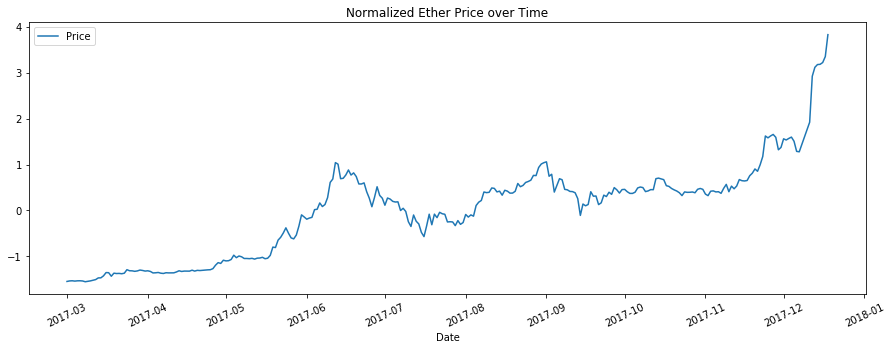

In [11]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

df_no_date = df.drop('Date', axis=1)

# Standardize features by removing the mean and scaling to unit variance
scaled_no_date = StandardScaler().fit_transform(df_no_date)
scaled_df_no_date = pd.DataFrame(scaled_no_date, index=df_no_date.index, columns=df_no_date.columns)
scaled_df = pd.concat([scaled_df_no_date, df['Date'].to_frame()], axis=1)

scaled_df.plot(title='Normalized Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
plt.show()
plt.close()

The price stagnates for the first 3 months, then spikes exponentially. From June to the beginning of December, the normalized price oscillates between 0 and 1.5. Then, the price spikes in December.

## Standardized Ether Transaction Count over Time

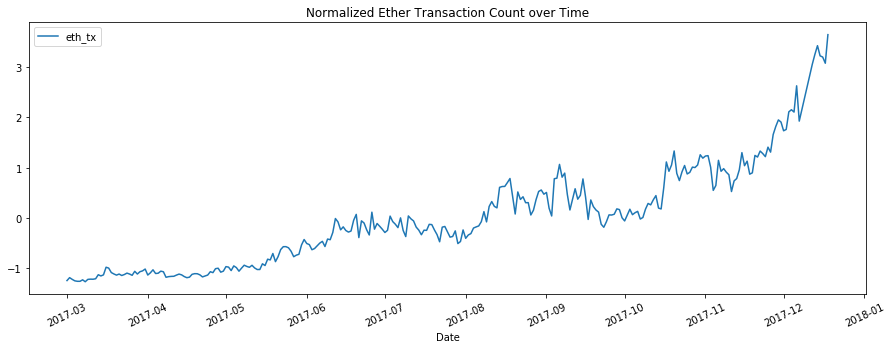

In [12]:
scaled_df.plot(title='Normalized Ether Transaction Count over Time', x='Date', y='eth_tx', rot=25, figsize=(15,5))
plt.show()
plt.close()

The ether transaction count, like price, stagnates for the first 3 months and then increases for the remaining months. It is evident that in general, as price increases, so does transaction count and as price decreases, so does transaction count.

## Standardized Ether Price and Transaction Count vs Time

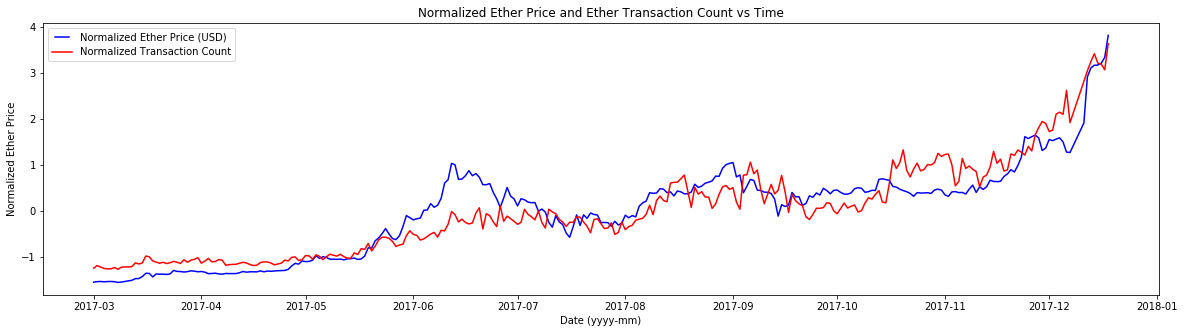

In [13]:
from matplotlib.legend_handler import HandlerLine2D

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Normalized Ether Price and Ether Transaction Count vs Time')
line1, = ax.plot(scaled_df['Date'], scaled_df['Price'], 'b', label='Normalized Ether Price (USD)')
line2, = ax.plot(scaled_df['Date'], scaled_df['eth_tx'], 'r', label='Normalized Transaction Count')
ax.set_xlabel('Date (yyyy-mm)')
ax.set_ylabel('Normalized Ether Price')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

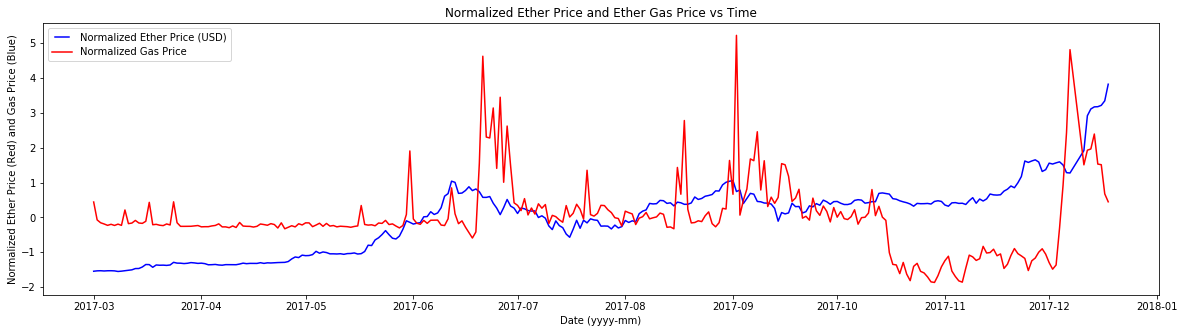

In [14]:
from matplotlib.legend_handler import HandlerLine2D

fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Normalized Ether Price and Ether Gas Price vs Time')
line1, = ax.plot(scaled_df['Date'], scaled_df['Price'], 'b', label='Normalized Ether Price (USD)')
line2, = ax.plot(scaled_df['Date'], scaled_df['eth_gasprice'], 'r', label='Normalized Gas Price')
ax.set_xlabel('Date (yyyy-mm)')
ax.set_ylabel('Normalized Ether Price (Red) and Gas Price (Blue)')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
plt.show()

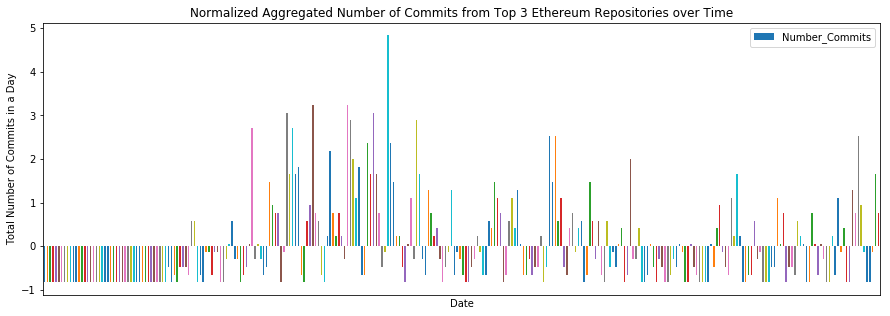

In [15]:
import matplotlib.ticker as plticker

scaled_df.plot(title='Normalized Aggregated Number of Commits from Top 3 Ethereum Repositories over Time', x='Date', y='Number_Commits', kind='bar', rot=45, figsize=(15,5))
plt.tick_params(bottom='off', labelbottom='off')
plt.ylabel('Total Number of Commits in a Day')
plt.show()
plt.close()

The normalized aggregated number of commits doesn't seem to have a correlation to Ether price.

# Univariate ARIMA

To perform univariate ARIMA, you need **stationary time series** data. 

In [16]:
# Format time series data for ARIMA model with Date as the index
def create_arima_ts(df):
    return df[['Date', 'Price']].set_index('Date')

ts = create_arima_ts(df)
print(ts.head())

             Price
Date              
2017-12-18  785.99
2017-12-17  717.71
2017-12-16  699.09
2017-12-15  693.58
2017-12-14  692.83


## Check for Stationarity of Data
1. Perform an **Augmented Dickey-Fuller (ADF) Test** to test stationarity of the original timeseries data.
2. Compare **ADF test statistic** and **Critical Values**, specifically the critical value at **1%**, to determine whether or not the data is stationary. The more negative the ADF test statistic, the more likely it is that one would reject the **null hypothesis** (i.e. the timeseries data is stationary). The ADF test statistic should be more negative than the ADF critical value at 1%, which would mean that there would be a high probability that the stationarity of the data can be taken as truth. Therefore, I want a large negative ADF test statistic, one that is less than the critical value at 1%, so that I can ensure my time series is stationary.
3. If the data is not proven stationary in **step 2**, I will perform differencing to make it stationary, by modeling the differences of the terms and not the actual term. For instance, **x(t) – x(t – 1)**

In [17]:
from statsmodels.tsa.stattools import adfuller

'''
Print ADF Results
'''
def print_adf(ts):
    COLUMNS = ts.columns
    for column in COLUMNS:
        augmented_dickey_fuller = adfuller(ts[column])
        print('\nADF Results for column:', column)
        print('ADF Statistic: %f' % augmented_dickey_fuller[0])
        print('p-value: %f' % augmented_dickey_fuller[1])
        print('Critical Values:')
        for key, value in augmented_dickey_fuller[4].items():
            print('\t%s: %.3f' % (key, value))

C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### ADF Test on Original Time Series Data

On the original time series data, test for stationarity.

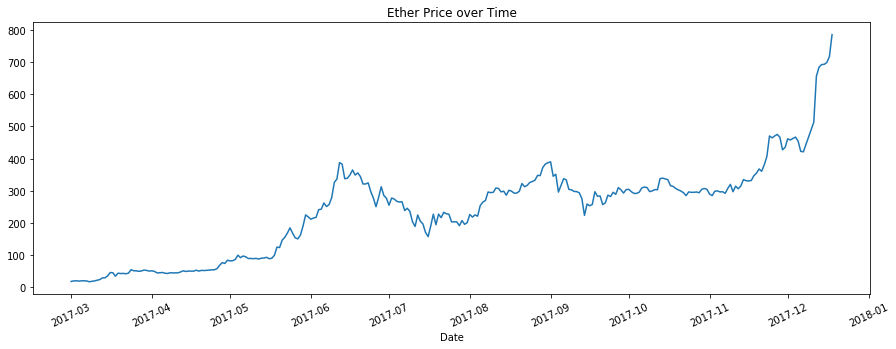


ADF Results for column: Price
ADF Statistic: -3.988920
p-value: 0.001470
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


In [18]:
import matplotlib.pyplot as plt

# Plot original price vs time
ts['Price'].plot(title='Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5))
plt.show()
plt.close()

# Print ADF Results
print_adf(ts)

Running an ADF test on the original time series data returns:

* **ADF Statistic:** -3.989
* **p-value:** 0.015
* **Critical Values:**
    1%: -3.453
	5%: -2.872
	10%: -2.572
    
The ADF test statistic is -3.989 and less than the value of -3.453 at 1%. Our data could be **stationary** given this ADF test. Since the ADF statistic is not much more negative than the critical value at 1%, it would be safe to take a first time difference just to make sure that it is stationary. The graph of Price over time makes the data look non-stationary, since the mean of the data is varying over time. On average, the price of Ether is growing over time.

### ADF on First Differences of the Ether Price Data

To make the timeseries data stationary, I will take the first difference of the Ether price data. On the first time-differenced data, check for stationarity.

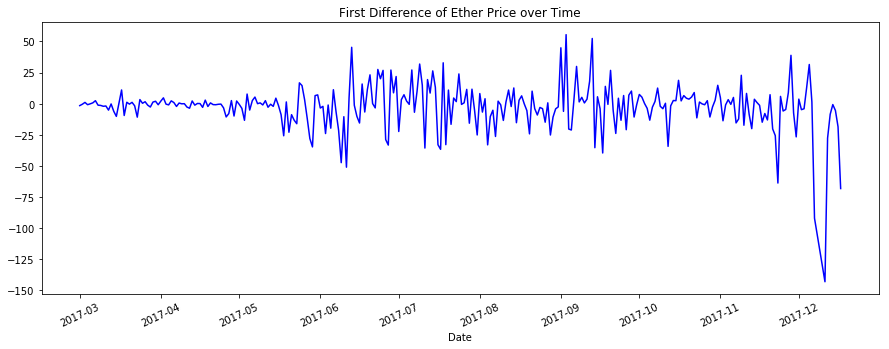


ADF Results for column: Price
ADF Statistic: -14.585564
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


In [19]:
# Take a time difference of the time series data
def time_difference(ts):
    differenced_ts = ts.diff()
    differenced_ts.dropna(inplace=True)
    return differenced_ts

ts_first_differences = time_difference(ts)

# Plot first differences of Ether Price vs time
ax = ts_first_differences['Price'].plot(title='First Difference of Ether Price over Time', x='Date', y='Price', rot=25, figsize=(15,5), color='blue')
plt.show()
plt.close()

# Print ADF Results
print_adf(ts_first_differences)

Running an ADF test on the transformed time series data returns:

* **ADF Statistic:** -14.586
* **p-value:** 0.000000
* **Critical Values:**
	1%: -3.453
	5%: -2.872
	10%: -2.572

The ADF test statistic is -14.586 and is a lot less than the value of -3.453 at 1%. This means that the time series data are **stationary**.

## Find the right parameters to be used in the ARIMA model

To find the parameters of the ARIMA model, I need to answer two questions:
1. **Is this an AR or MA process?**
2. **What is the order of the AR or MA process?**

I will use a **Total Correlation Chart** (also known as Auto – correlation Function / ACF) to determine whether is is an AR or MA process. ACF is a plot of total correlation between different lag functions. For example, I will compare my autocorrelation plot with the two plots below. Note: an AR process will have a **gradual correlation decrease**, a MA process will have an **abrupt decrease**:

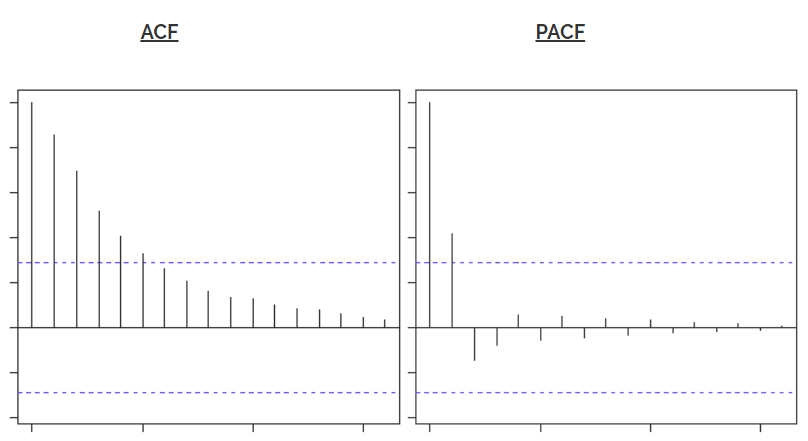

Figure from https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/

Both ACF and PACF plots show a sharp decrease in correlations and both have negative autocorrelations at lag 2. Therefore, this is both an AR and MA series.

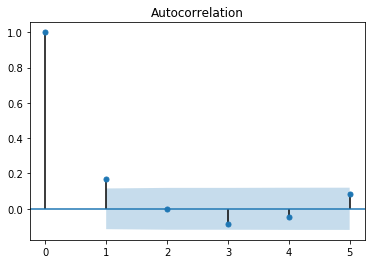

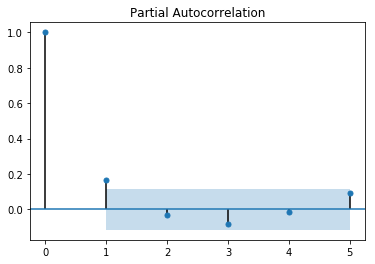

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(x=ts_first_differences['Price'], lags=5)
fig = plot_pacf(x=ts_first_differences['Price'], lags=5)

By viewing the autocorrelation plot and partial autocorrelation plot, I predict that (2,1,2) are the best hyperparameters

### Plot of Ether Time Series Data to be fed into ARIMA Model

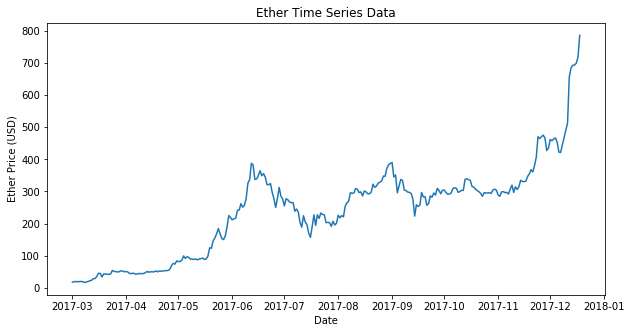

In [21]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(figsize=(10, 5))
ax.plot(ts.index,ts['Price'])
ax.set_title('Ether Time Series Data')
ax.set_xlabel('Date')
ax.set_ylabel('Ether Price (USD)')
plt.show()

### Perform a Rolling Forecast with Univariate ARIMA Models

1. `TimeSeriesSplit` will be used to create a `time series cross validator` called splits. This cross validator will be used to provide multiple training and testing splits of the ether price data. 
2. For each split, perform a rolling forecast with a univariate ARIMA model, i.e. for each new price observation, create a new model. 
3. Make a new price prediction for each each model.

(Adapted from  https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)

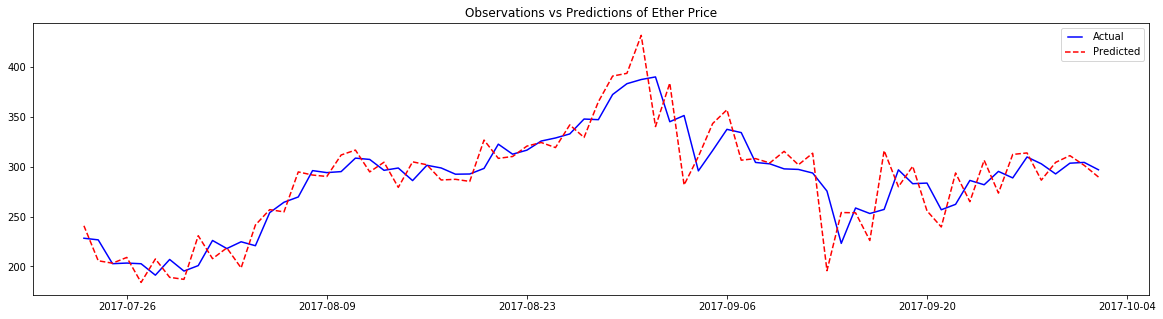

Test MSE: 541.923
Test RMSE: 23.279


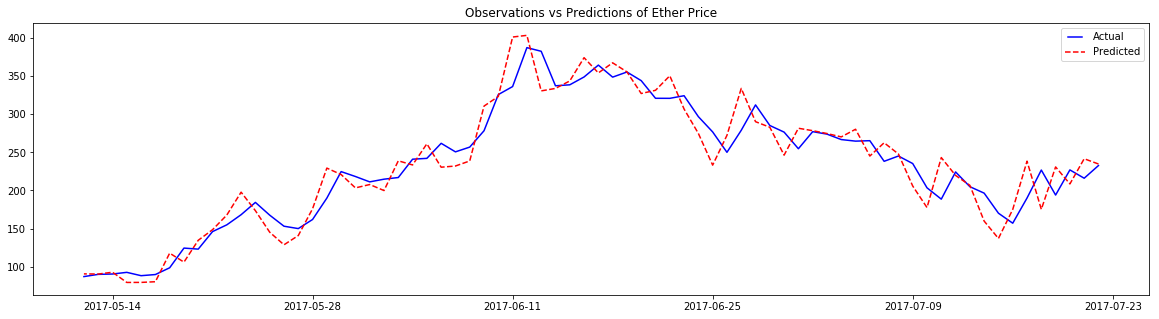

Test MSE: 600.679
Test RMSE: 24.509


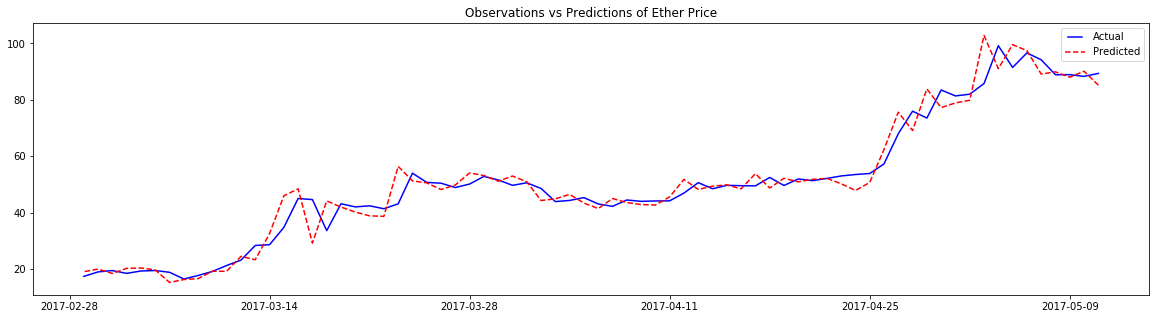

Test MSE: 23.956
Test RMSE: 4.894


In [22]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.legend_handler import HandlerLine2D
from math import sqrt
from statsmodels.tsa.arima_model import ARIMA

def plot_ARIMA_rolling_forecast(ts, order):
    splits = TimeSeriesSplit(n_splits=3)
    for train_indices, test_indices in splits.split(ts):
        # Split into training and testing sets
        train = ts.iloc[train_indices]
        test = ts.iloc[test_indices]

        # Drop NaN
        train = train.dropna()
        test = test.dropna()

        # Historical Ether prices
        history = [x for x in train['Price']]

        # Rolling forecast with the ARIMA model - make a new model for each new observation
        predictions = list()
        for t in range(len(test)):
            model = ARIMA(history, order=order)
            model_fit = model.fit(disp=0)
            output = model_fit.forecast() # To predict 7 steps out, set steps = 7 
            yhat = output[0][0]
            predictions.append(yhat)
            obs = test.iloc[t]['Price']
            history.append(obs)
            # print('predicted=%f, expected=%f' % (yhat, obs))

        # Plot price predictions and actual values for each split
        fig, ax = pyplot.subplots(figsize=(20, 5))
        ax.set_title('Observations vs Predictions of Ether Price')
        line1, = ax.plot(test.index,test['Price'], 'b', label='Actual')
        line2, = ax.plot(test.index, predictions, 'r--', label='Predicted')
        plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})
        pyplot.show()

        # Report the mse and rmse for each split
        mse = mean_squared_error(test['Price'].values, predictions)  
        rmse = sqrt(mean_squared_error(test['Price'].values, predictions))
        print('Test MSE: %.3f' % mse)
        print('Test RMSE: %.3f' % rmse)
        
plot_ARIMA_rolling_forecast(ts, (2,2,0))

The univariate ARIMA model does reasonably well for each of the 3 train test splits returned by `TimeSeriesSplit`.

In [23]:
from math import ceil

def round_to_hundredth(value):
    return ceil(value * 100.0) / 100.0

'''
Gets the difference between a list of actual values and a list of predicted values, 
rounded to the nearest hundredth.
'''
def differences(actual, predicted):
    differences = []
    for i, value in enumerate(actual):
        diff = abs(value - predicted[i])
        differences.append(round_to_hundredth(diff))
    return differences

def prediction_summary(actual, predicted):
    rounded_actual = [round_to_hundredth(value) for value in actual]
    rounded_predicted = [round_to_hundredth(value) for value in predicted]
    print("actual:", rounded_actual)
    print("predicted:", rounded_predicted)
    ARIMA_last_seven_differences = differences(rounded_actual, rounded_predicted)
    print("differences:", ARIMA_last_seven_differences)
    rmse = sqrt(mean_squared_error(rounded_actual, rounded_predicted))
    print('test RMSE: %.3f' % rmse)

### Perform a 7-Day Price Forcast with Univariate ARIMA

Train on all but the last 7 data points.

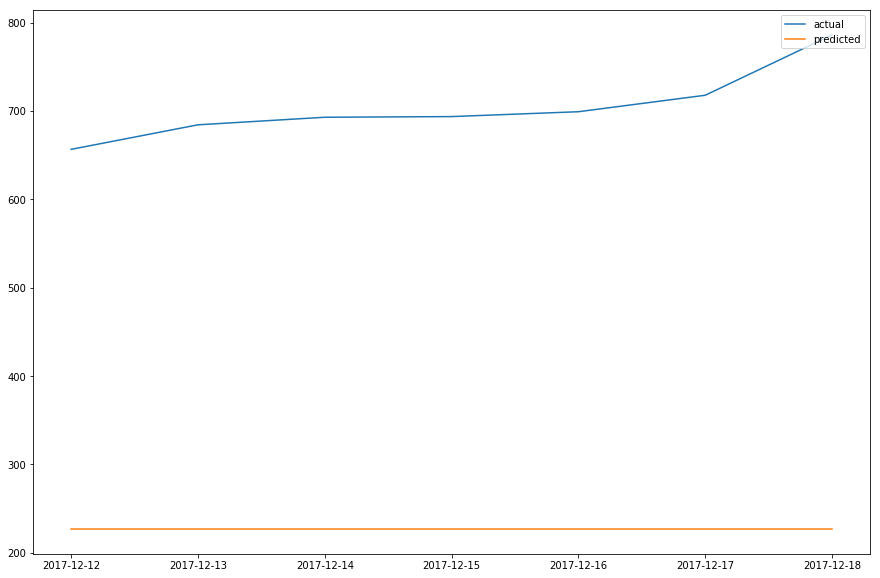

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [226.9, 226.9, 226.9, 226.9, 226.9, 226.9, 226.9]
differences: [429.62, 457.37, 465.94, 466.69, 472.2, 490.82, 559.09]
test RMSE: 478.850


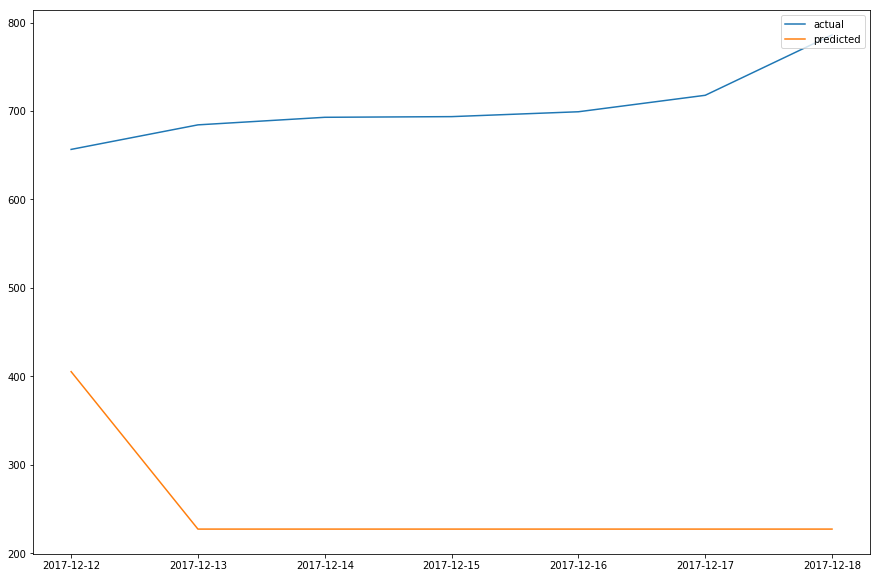

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [405.23, 227.19, 227.19, 227.19, 227.19, 227.19, 227.19]
differences: [251.29, 457.08, 465.65, 466.4, 471.9, 490.53, 558.8]
test RMSE: 460.119


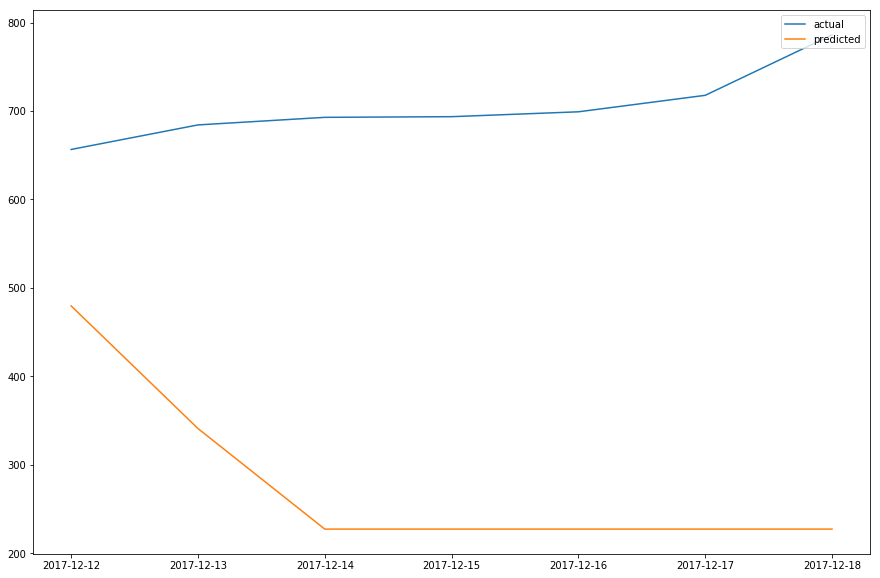

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [479.75, 341.19, 227.51, 227.51, 227.51, 227.51, 227.51]
differences: [176.77, 343.08, 465.33, 466.08, 471.59, 490.21, 558.48]
test RMSE: 440.337


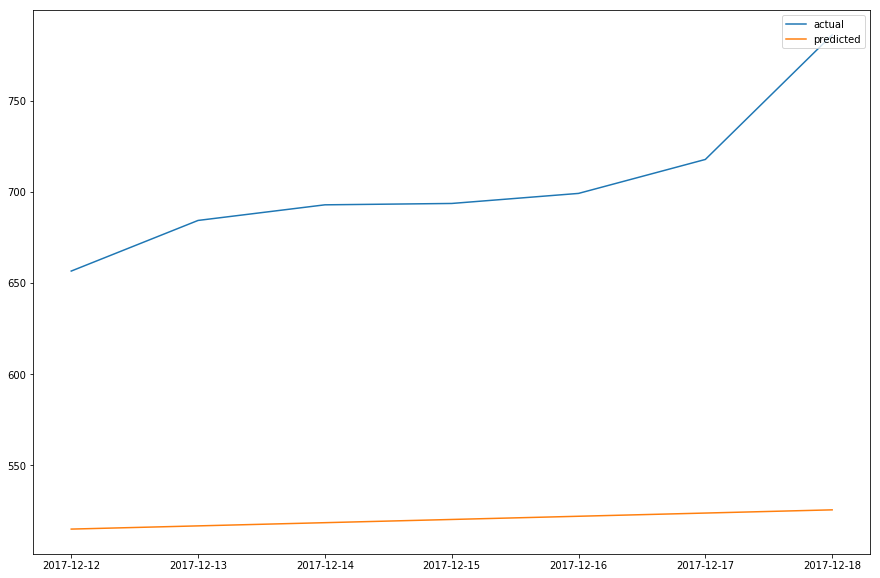

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [515.05, 516.81, 518.57, 520.33, 522.09, 523.85, 525.6]
differences: [141.48, 167.47, 174.26, 173.25, 177.0, 193.86, 260.39]
test RMSE: 187.141


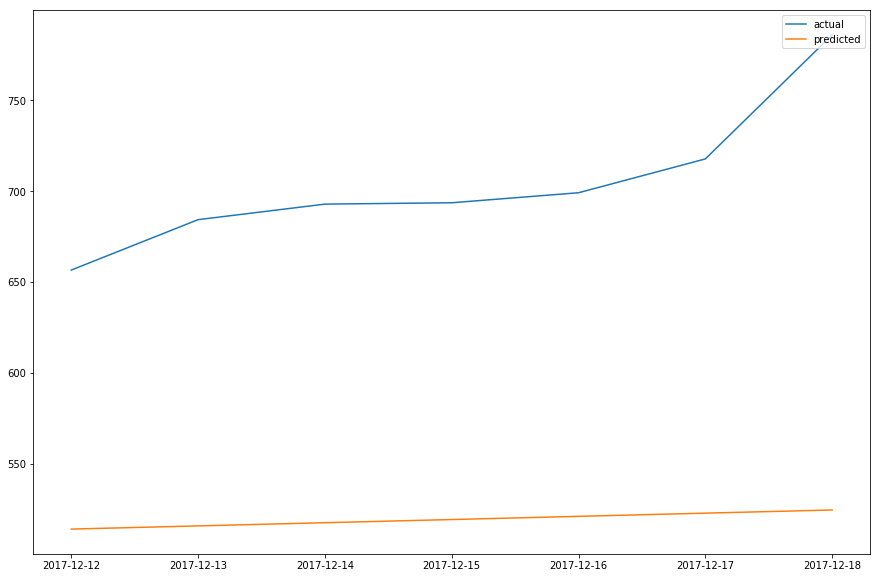

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [513.92, 515.68, 517.43, 519.18, 520.94, 522.69, 524.45]
differences: [142.61, 168.6, 175.41, 174.41, 178.15, 195.02, 261.54]
test RMSE: 188.267


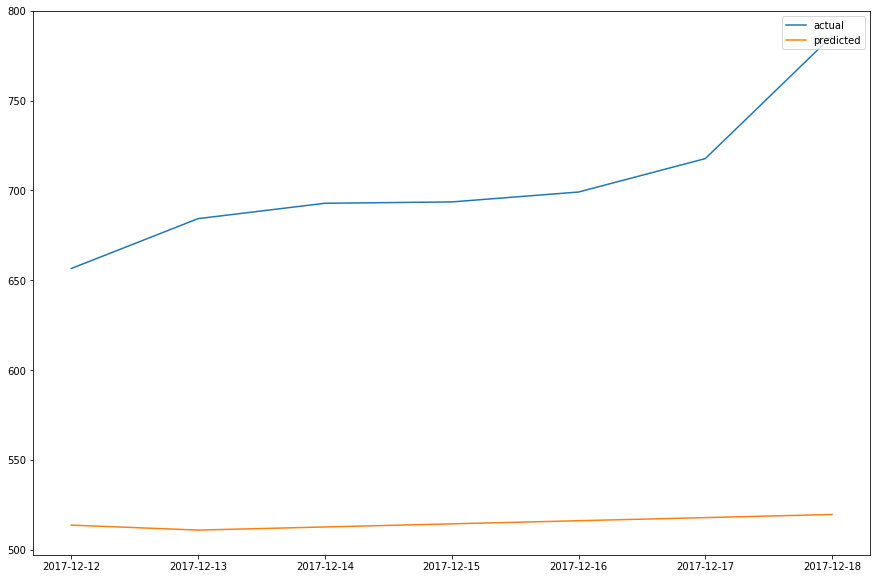

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [513.69, 510.92, 512.65, 514.39, 516.13, 517.87, 519.61]
differences: [142.83, 173.35, 180.19, 179.2, 182.97, 199.85, 266.38]
test RMSE: 192.500


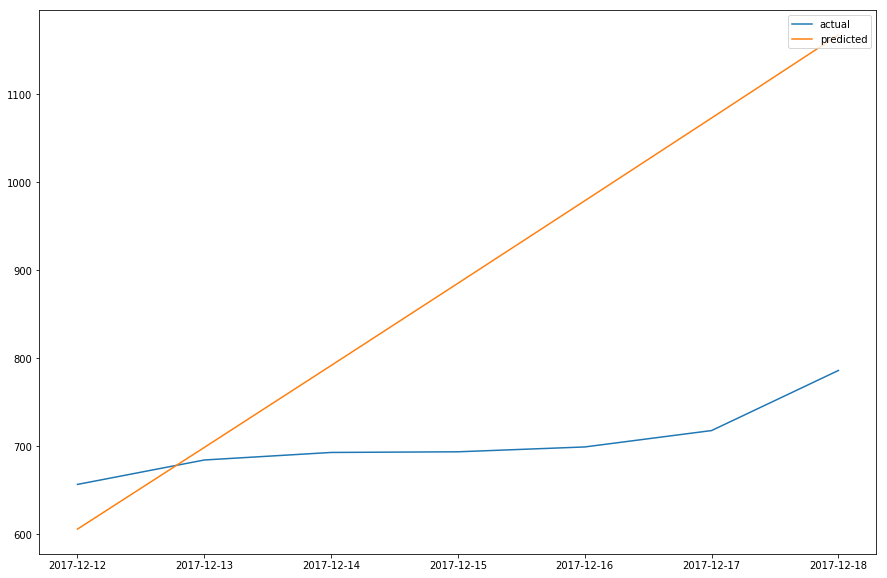

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [605.76, 698.54, 791.65, 885.08, 978.83, 1072.9, 1167.3]
differences: [50.76, 14.27, 98.82, 191.5, 279.74, 355.2, 381.31]
test RMSE: 238.756


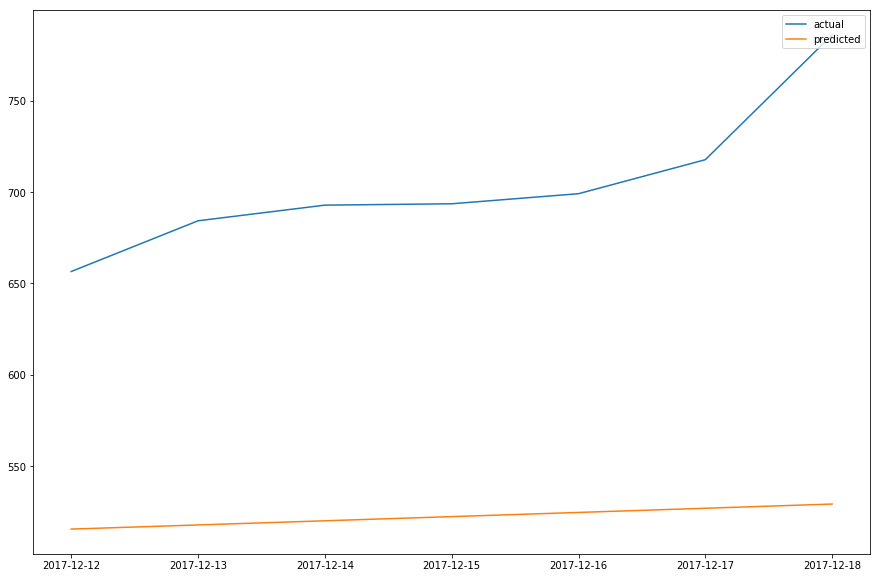

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [515.56, 517.83, 520.1, 522.39, 524.67, 526.97, 529.26]
differences: [140.97, 166.44, 172.73, 171.2, 174.43, 190.74, 256.73]
test RMSE: 184.943


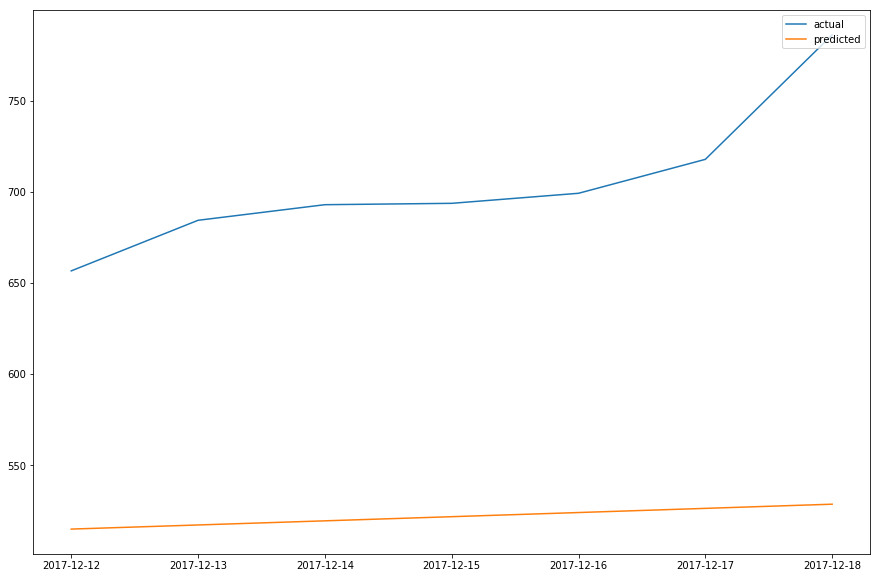

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.84, 517.1, 519.37, 521.65, 523.93, 526.21, 528.5]
differences: [141.68, 167.17, 173.47, 171.94, 175.17, 191.5, 257.49]
test RMSE: 185.673


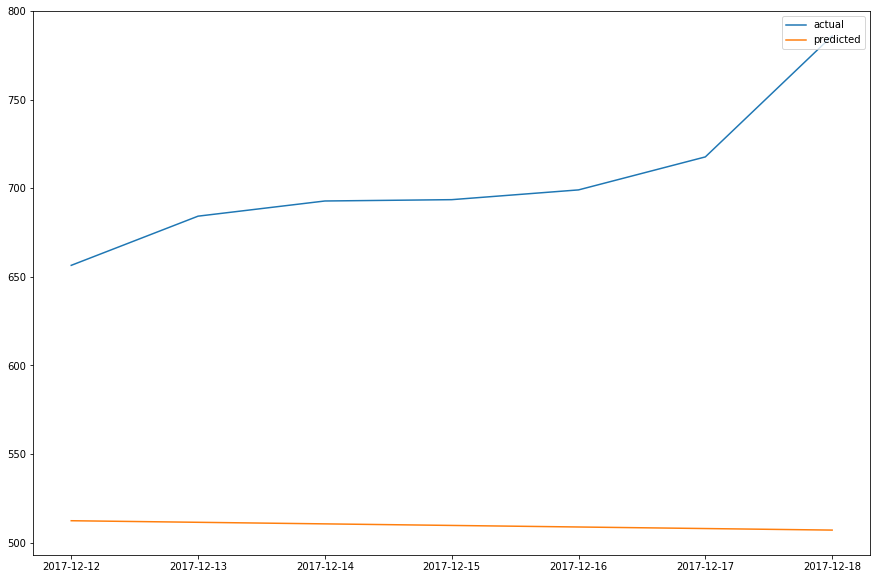

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [512.4, 511.52, 510.63, 509.75, 508.87, 507.99, 507.12]
differences: [144.12, 172.75, 182.21, 183.84, 190.23, 209.73, 278.87]
test RMSE: 198.400


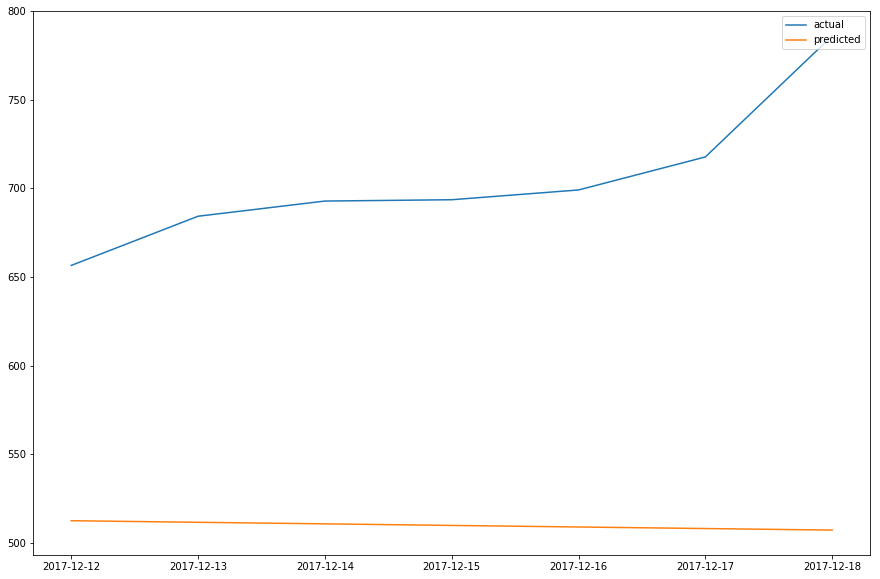

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [512.52, 511.63, 510.75, 509.86, 508.98, 508.11, 507.23]
differences: [144.0, 172.64, 182.09, 183.73, 190.11, 209.61, 278.76]
test RMSE: 198.288


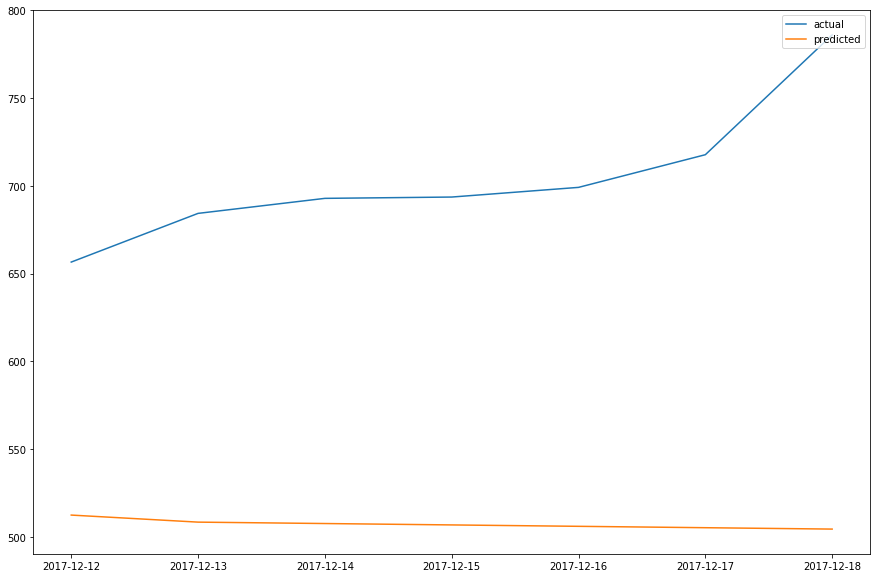

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [512.32, 508.3, 507.5, 506.71, 505.91, 505.12, 504.33]
differences: [144.2, 175.97, 185.34, 186.88, 193.18, 212.6, 281.67]
test RMSE: 201.023


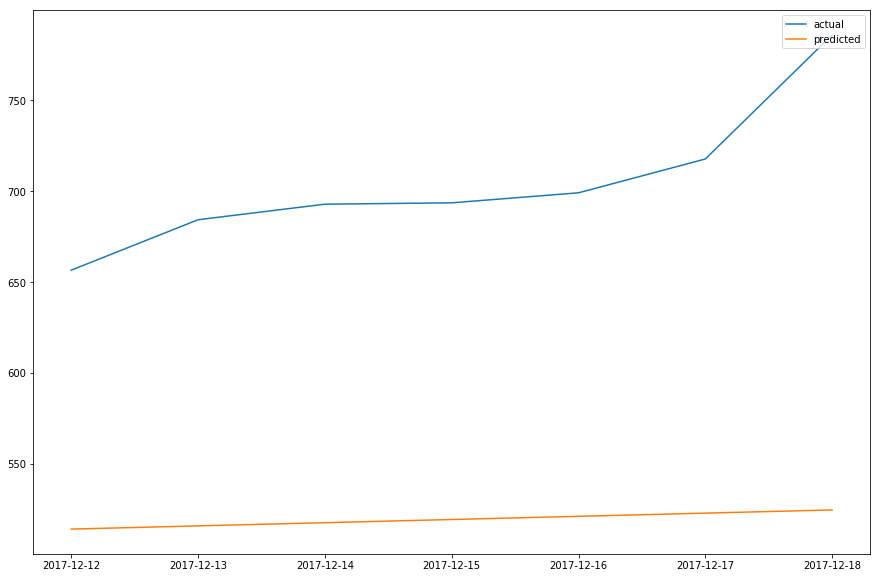

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.03, 515.79, 517.55, 519.3, 521.06, 522.81, 524.57]
differences: [142.49, 168.48, 175.29, 174.29, 178.04, 194.91, 261.42]
test RMSE: 188.151
non stationary
non stationary
non stationary
non stationary


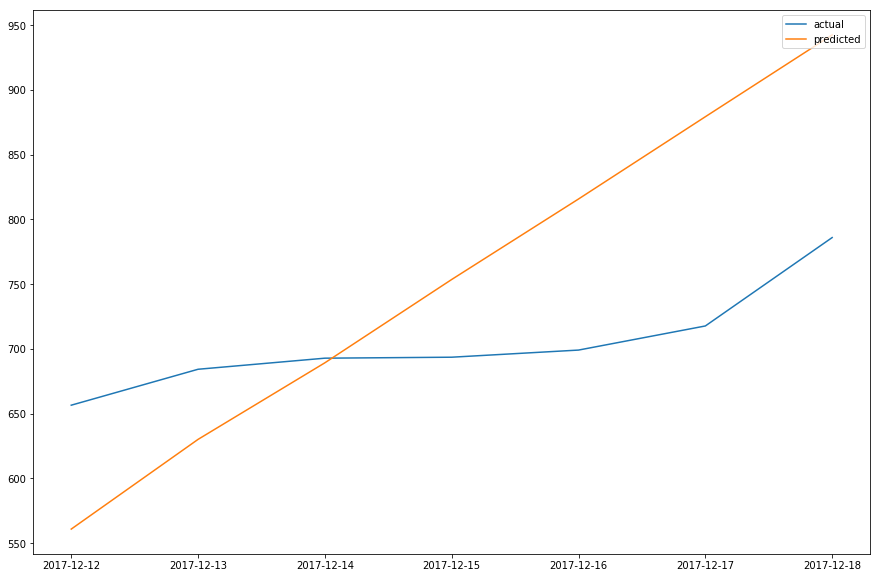

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [560.83, 630.12, 689.27, 753.62, 815.79, 879.32, 942.52]
differences: [95.69, 54.15, 3.57, 60.04, 116.7, 161.62, 156.53]
test RMSE: 106.867


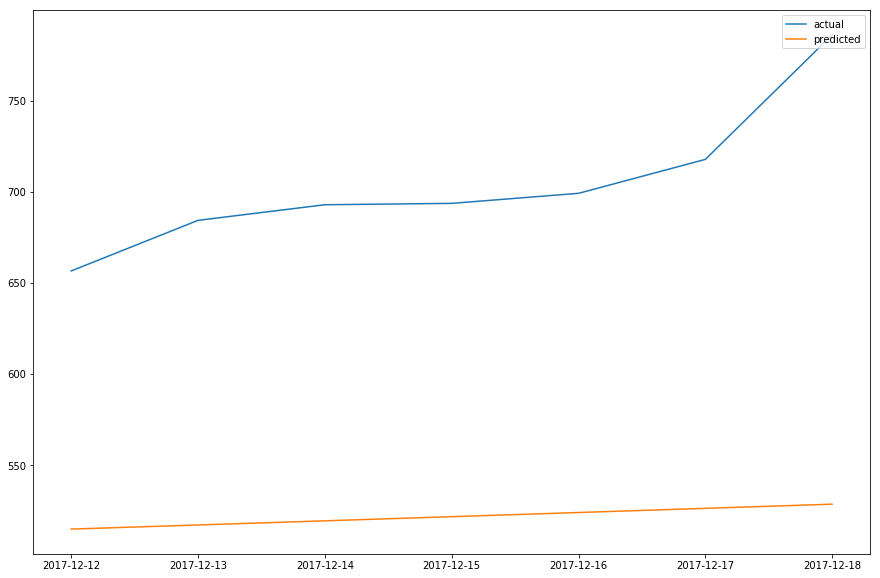

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.9, 517.17, 519.44, 521.71, 524.0, 526.28, 528.57]
differences: [141.62, 167.11, 173.39, 171.87, 175.1, 191.44, 257.42]
test RMSE: 185.607


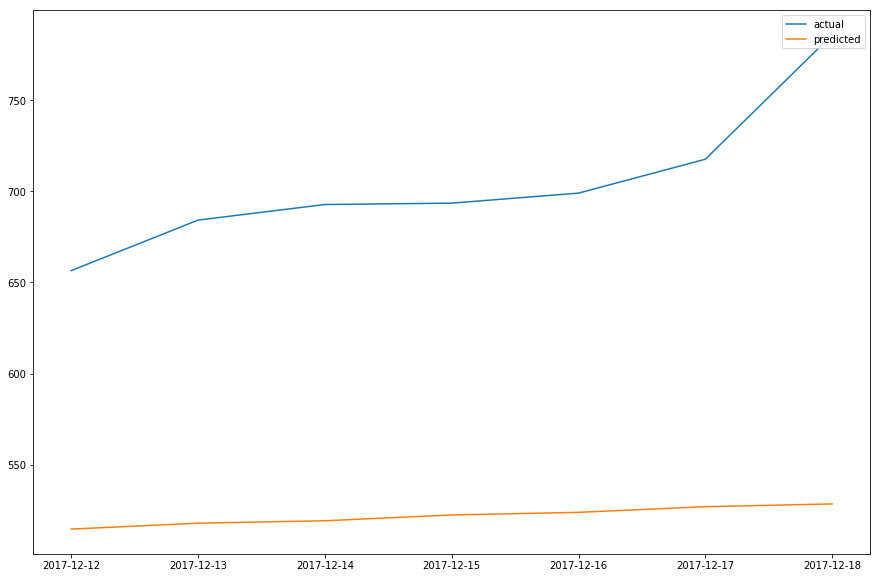

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.55, 517.79, 519.13, 522.3, 523.74, 526.85, 528.37]
differences: [141.98, 166.48, 173.71, 171.29, 175.36, 190.86, 257.62]
test RMSE: 185.520


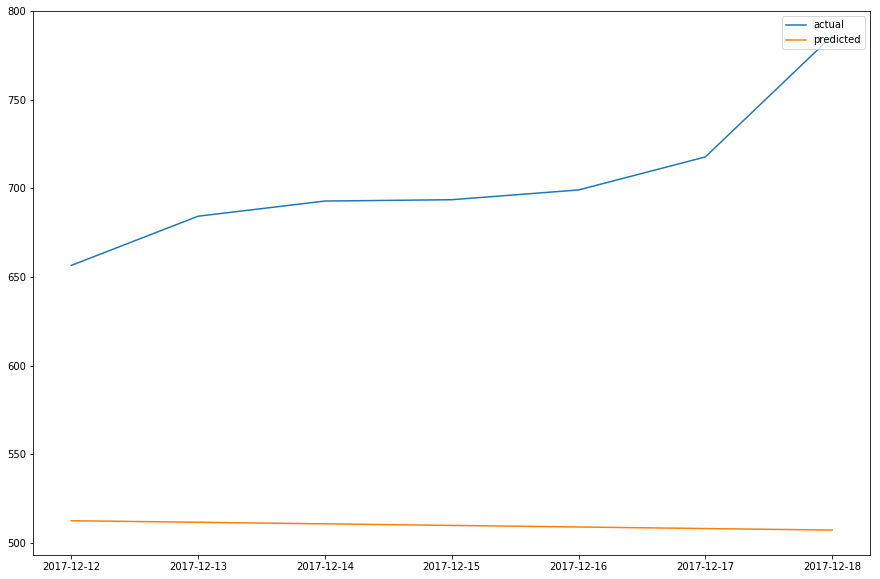

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [512.51, 511.62, 510.73, 509.85, 508.97, 508.09, 507.21]
differences: [144.01, 172.65, 182.11, 183.73, 190.12, 209.63, 278.79]
test RMSE: 198.303


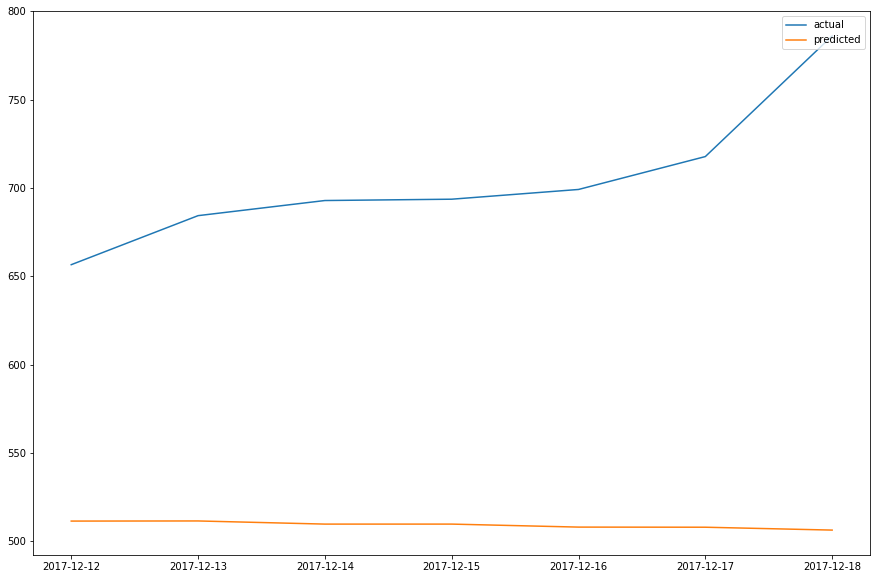

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [511.43, 511.5, 509.72, 509.72, 508.02, 507.95, 506.33]
differences: [145.09, 172.77, 183.11, 183.86, 191.08, 209.77, 279.67]
test RMSE: 198.908
non stationary
non stationary


C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:584: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/
C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:585: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()
C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:586: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/
C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: overflow encountered in exp
  (1+np.exp(-params))).copy()
C:\Users\Steph\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:587: RuntimeWarning: invalid value encountered in true_divide
  (1+np.exp(-params))).copy()


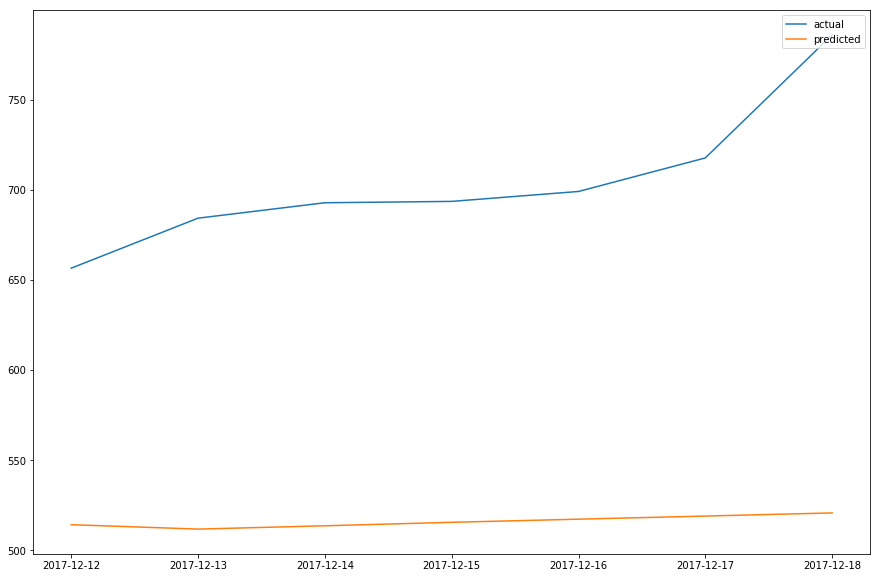

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.13, 511.69, 513.52, 515.45, 517.19, 518.92, 520.66]
differences: [142.39, 172.58, 179.32, 178.13, 181.9, 198.8, 265.34]
test RMSE: 191.590


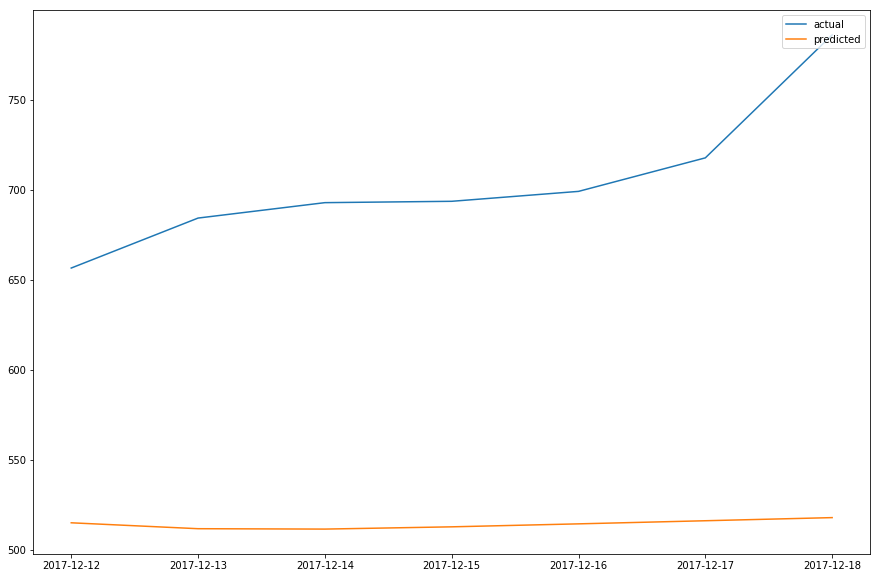

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [515.04, 511.76, 511.54, 512.79, 514.45, 516.18, 517.91]
differences: [141.49, 172.51, 181.3, 180.8, 184.64, 201.54, 268.09]
test RMSE: 193.428
non stationary
non stationary


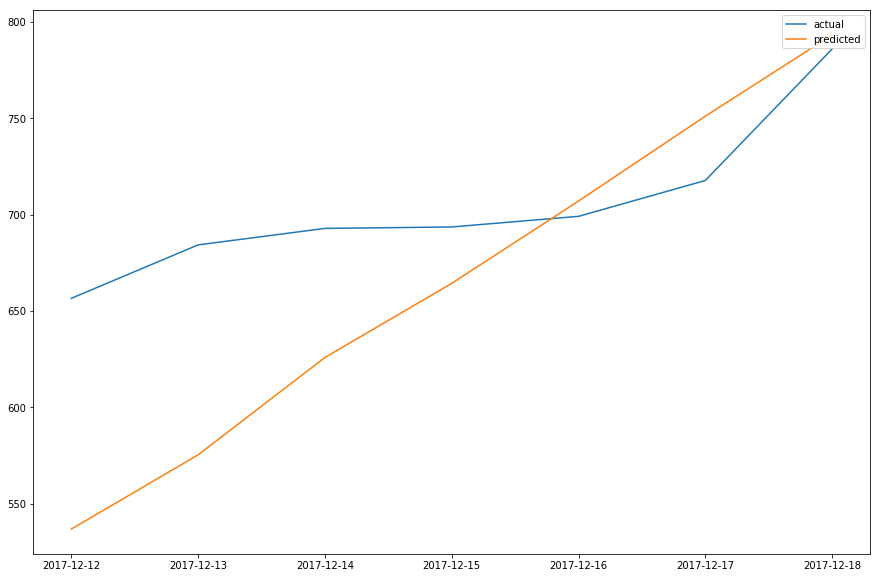

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [536.77, 575.3, 625.83, 664.32, 707.04, 751.09, 793.27]
differences: [119.75, 108.98, 67.0, 29.26, 7.95, 33.38, 7.28]
test RMSE: 68.442


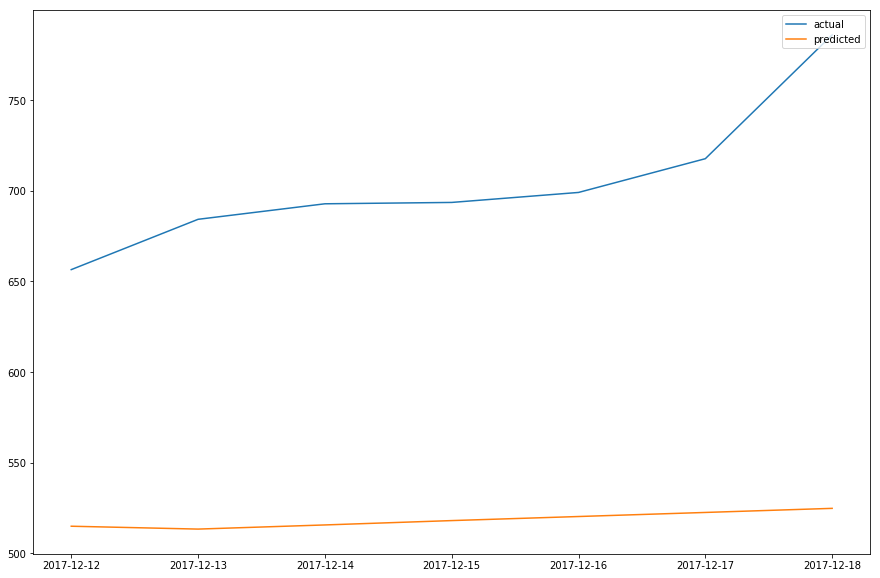

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [514.98, 513.4, 515.68, 518.09, 520.33, 522.58, 524.83]
differences: [141.54, 170.87, 177.16, 175.49, 178.76, 195.13, 261.16]
test RMSE: 188.848


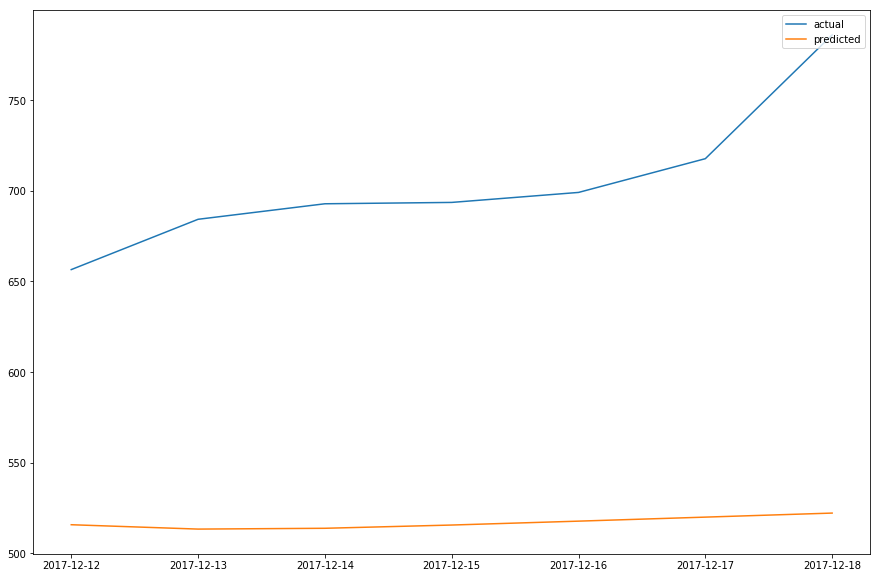

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [515.78, 513.37, 513.81, 515.6, 517.75, 519.97, 522.2]
differences: [140.74, 170.9, 179.03, 177.98, 181.35, 197.74, 263.79]
test RMSE: 190.604

Best RMSE 68.44647915037018
Best order:
(2, 2, 0)
Prediction with best hyperparameters:


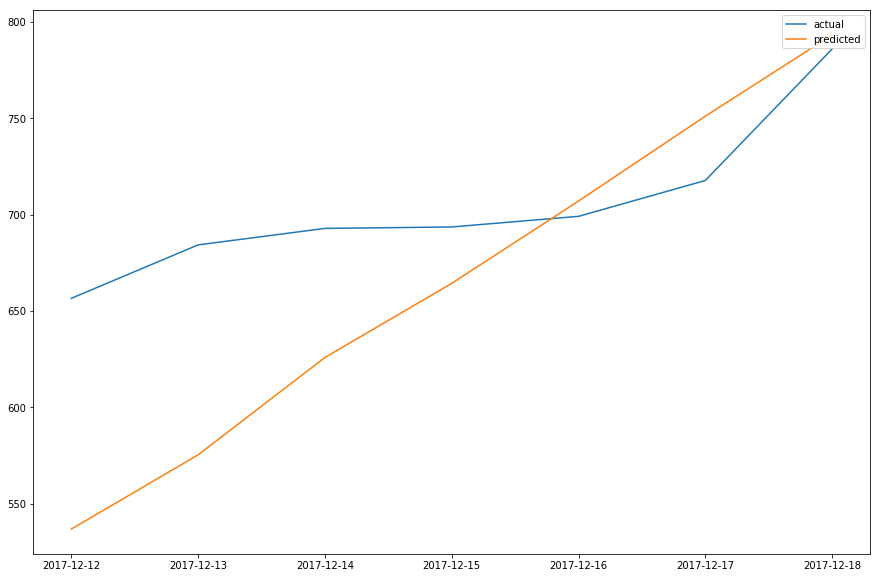

In [24]:
import numpy as np

def ARIMA_seven_day_forecast(ts, order):
    # Get split index
    train_index = len(ts) - 7 # subtract last 7 days to predict

    # Split into Training and Testing Data
    train = ts[0:train_index]
    test = ts[train_index:len(ts)]

    # Fit ARIMA Model
    model = ARIMA(train['Price'], order=order)
    try:
        model_fit = model.fit(disp=0)
        forecast = model_fit.forecast(steps=7) # To predict 7 steps out, set steps = 7 
        ARIMA_actual = test['Price'].values
        ARIMA_predicted = forecast[0]

        # Plot actual vs predicted values
        DATES = ts.index

        plt.figure(figsize=(15, 10))
        plt.plot(DATES[train_index:], ARIMA_actual, label='actual')
        plt.plot(DATES[train_index:], ARIMA_predicted, label='predicted')
        plt.legend(['actual', 'predicted'], loc='upper right')
        plt.show()
        return ARIMA_actual, ARIMA_predicted, model_fit
    except:
        print("non stationary")

def find_optimal_ARIMA_parameters(ts):
    p_values = [0, 1, 2]
    d_values = range(0, 3)
    q_values = range(0, 3)

    best_rmse = 10000 # some large number
    best_order = (0,0,0)
    for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        ARIMA_actual, ARIMA_predicted, model_fit = ARIMA_seven_day_forecast(ts_reversed, order)
                        prediction_summary(ARIMA_actual, ARIMA_predicted)
                        rmse = sqrt(mean_squared_error(ARIMA_actual, ARIMA_predicted))
                        if rmse < best_rmse:
                            best_rmse = rmse
                            best_order = order
                    except: 
                        print("non stationary")
    return best_rmse, best_order

ts_reversed = ts.copy(deep=True).iloc[::-1] # reverse the dataframe to predict in the future
best_rmse, best_order = find_optimal_ARIMA_parameters(ts_reversed)
print("\nBest RMSE " + str(best_rmse) + "\nBest order:")
print(best_order)
print("Prediction with best hyperparameters:")
ARIMA_actual, ARIMA_predicted, model_fit = ARIMA_seven_day_forecast(ts_reversed, best_order)

The univariate ARIMA model does not do very well to predict values a week into the future. Since Ether price is so volatile and only price is used as a feature in prediction, there's a lot of room for error in prediction. There's just too much variation in price to make an accurate prediction with univariate ARIMA. A multivariate model should be able to capture the variation in price better.

### Residual Plot

The residuals are difference between the actual and predicted values. The residual plot should look random around 0 and do not show any trend, so this means that there aren't any missing trends or elements in the ARIMA model.

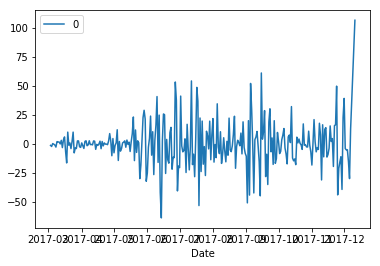

In [25]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

This is the density plot of the residual error values. The errors look like they are in a Gaussian distribution, and are centered at 0. The mean is around 0, so this suggests that there is not much bias in the prediction. 

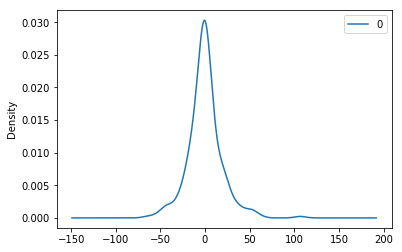

                0
count  281.000000
mean    -0.005373
std     19.058778
min    -63.828118
25%     -8.586988
50%     -0.605053
75%      7.137367
max    106.660395


In [26]:
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

This is an autocorrelation plot. Autocorrelation determines the amount of the relationship between a current observation and previous observations. There is not an obvious autocorrelation trend in the plot. It seems that earlier lags have larger autocorrelation. This makes sense, because the first few months of Ether price data showed generally low Ether price data with low variation in price. Thus, there is a bit of a relationship between early Ether price timeseries data points. However, in later months, Ether price data was a lot more random, so the autocorrelations for later timeseries data is closer to 0 than the autocorrelations in earlier months which were much larger in magnitude.

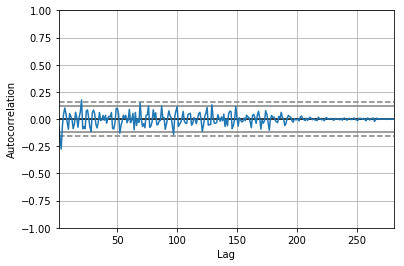

In [27]:
from pandas.plotting import autocorrelation_plot

plt = autocorrelation_plot(residuals)

# Long-Short Term Memory (LSTM) Recurrent Neural Network

Plot the features that will contribute to the LSTM RNN.

### Feature Selection

Perform feature selection to identify the input features that are most predictive.

Price
eth_address
eth_supply
eth_marketcap
eth_hashrate
eth_blocksize


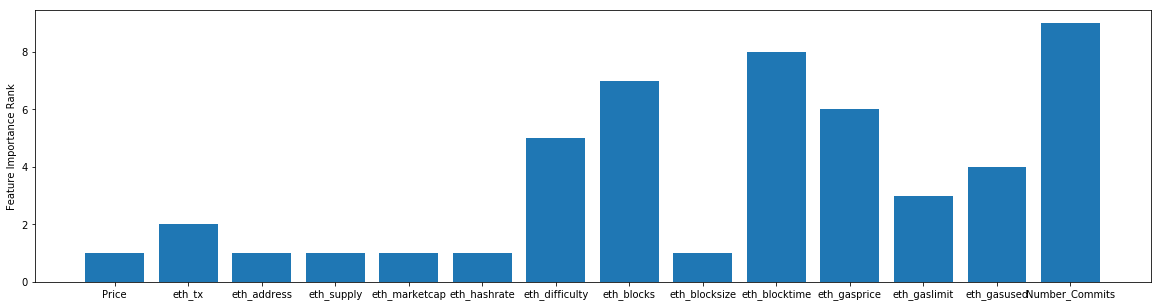

In [28]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt

X = df.drop(['Date'], 1).copy(deep=True).iloc[::-1]
y = df.drop('Date', 1)['Price'].copy(deep=True).iloc[::-1]

rfe = RFE(RandomForestRegressor(n_estimators=500, random_state=1), 6)
fit = rfe.fit(X, y)

names = X.columns.values

for i in range(len(fit.support_)):
    if fit.support_[i]:
        print(names[i])
        
# plot feature rank
plt.figure(figsize=(20, 5))
ax.set_title('Ranked Features by Importance')
names = X.columns.values
ticks = [i for i in range(len(names))]
plt.bar(ticks, fit.ranking_)
plt.xticks(ticks, names)
plt.ylabel('Feature Importance Rank')
plt.show()

This graph displays the rank of each feature. The lower the rank, the better the feature is at predicting the price of Ether. The top 6 features are **Price**, **eth_address**, **eth_supply**, **eth_marketcap**, **eth_hashrate**, **eth_blocksize**. I thought Ether gas price would be a more prominent predictor, since a high gas should deter transactions, but it is not as strong as I had thought. Also, I thought Ether transaction count would be a better predictor price than these features.

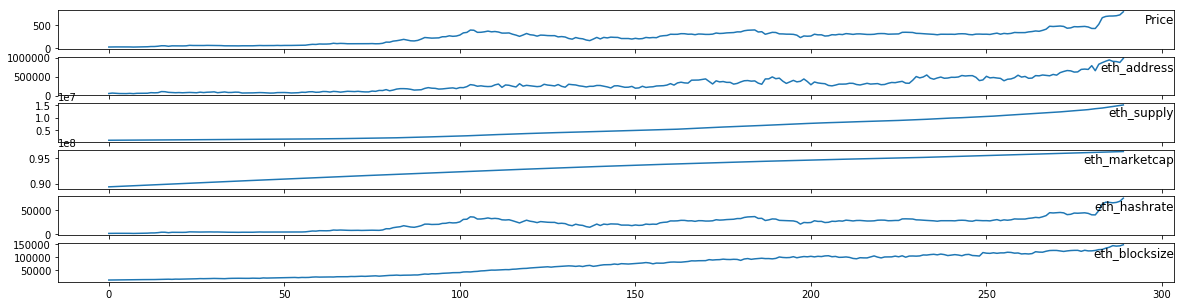

In [29]:
from matplotlib import pyplot as plt

SELECTED_COLUMNS = ['Price', 'eth_address', 'eth_supply', 'eth_marketcap', 'eth_hashrate', 'eth_blocksize']
VALUES = df.drop('Date', 1).copy(deep=True).iloc[::-1].values

i = 1
plt.figure(figsize=(20, 5))
for COLUMN in SELECTED_COLUMNS:
    plt.subplot(len(SELECTED_COLUMNS), 1, i)
    plt.plot(VALUES[:, i-1])
    plt.title(SELECTED_COLUMNS[i-1], y=0.5, loc='right')
    i += 1
plt.show()

### Create LSTM Time Series DataFrame

Drop columns that are not part of the selected column set.

In [30]:
def create_lstm_ts(df, selected_features):
    return df[['Date', *selected_features]].set_index('Date').iloc[::-1]

LSTM_TS = create_lstm_ts(df, SELECTED_COLUMNS)

### Stationize Ether Time Series Data

Make the time series data stationary by taking the first time difference, since there's an increasing trend in the data.

Price, eth_marketcap, eth_hashrate, and eth_blocksize are stationary. eth_address and eth_supply are still not stationary after one time difference:

```
ADF Results for column: Price
ADF Statistic: -5.227888
p-value: 0.000008
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572

ADF Results for column: eth_address
ADF Statistic: 2.259240
p-value: 0.998928
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572

ADF Results for column: eth_supply
ADF Statistic: -1.366851
p-value: 0.598061
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

ADF Results for column: eth_marketcap
ADF Statistic: -5.231881
p-value: 0.000008
Critical Values:
	1%: -3.454
	5%: -2.872
	10%: -2.572

ADF Results for column: eth_hashrate
ADF Statistic: -15.497114
p-value: 0.000000
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572

ADF Results for column: eth_blocksize
ADF Statistic: -3.956762
p-value: 0.001655
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.572
```

These two features will be removed from prediction.

In [31]:
if 'eth_address' and 'eth_supply' in LSTM_TS.columns:
    LSTM_TS = LSTM_TS.drop(['eth_address', 'eth_supply'], axis=1)
print(LSTM_TS.tail(7))

             Price  eth_marketcap  eth_hashrate  eth_blocksize
Date                                                          
2017-12-12  656.52    63183.80537   128931.8969          25607
2017-12-13  684.27    67295.16864   134096.1365          26216
2017-12-14  692.83    66779.18635   137629.7703          26049
2017-12-15  693.58    65897.05529   143758.2604          26180
2017-12-16  699.09    66735.52930   141945.8652          26389
2017-12-17  717.71    69146.64974   142954.4584          25965
2017-12-18  785.99    75741.14255   147283.4924          27932


# Fit LSTM RCNN
1. Apply min-max scaling to standardize the dataset
2. Split the dataset into train and test, where test is the most recent 7 days.
3. Reshape the inputs into 3D format expected by LSTMs: [samples, timesteps, features].
4. The optimal size of the hidden layer is usually between the size of the input and size of the output layers. In this case we have **290 input nodes and 1 output node**
5. Use the Mean Absolute Error (MAE) loss function and the Adam version of stochastic gradient descent.
6. Fit the model for a varying number of epochs with a batch size of **128**.
7. Keep track of both the training and test loss during training by setting the validation_data argument in the fit() function.

**Keep dimensions of weights in the exponential power of 2 (64, 128, 512, 1024).**

The below computation will take a few minutes and then output the model trained with different number of epochs.

Too few neurons in the hidden layers will result in underfitting, since there would be too few neurons in the hidden layer to adequately detect the signals in the data set. Too many neurons in the hidden layers may result in overfitting. 

In [32]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
pd.options.mode.chained_assignment = None

def difference_ts(ts, interval=1):  
    stationary_ts = ts.copy(deep=True)
    COLUMNS = ts.columns    
    for column in COLUMNS:
        diff = list()
        for i in range(interval, len(ts)):
            stationary_ts.loc[:, column][i] = ts.loc[:, column][i] - ts.loc[:, column][i - interval]
    return stationary_ts

def invert_time_difference(raw, yhat, interval):
    return yhat + raw[-interval]

def apply_minmax_scaling(train, test, features):
    # min max scaling
    SCALER = MinMaxScaler(feature_range=(-1, 1))
    TRAIN_SCALED = SCALER.fit_transform(train)
    TEST_SCALED = SCALER.fit_transform(test)
    
    # convert to DataFrame
    TRAIN_SCALED = pd.DataFrame(TRAIN_SCALED)
    TRAIN_SCALED.columns = features
    TEST_SCALED = pd.DataFrame(TEST_SCALED)
    TEST_SCALED.columns = features
    
    return TRAIN_SCALED, TEST_SCALED, SCALER

def invert_minmax_scaling(scaled_X_2d, scaled_y, scaler):
    # concat y and 2d X rows with no price, to a ts with all selected features
    scaled_Xy = concatenate((scaled_y, scaled_X_2d.loc[:, scaled_X_2d.columns != 'Price']), axis=1)
    inverted = scaler.inverse_transform(scaled_Xy)
    return inverted[:,0]

def train_test_split(ts, test_set_size):
    TRAIN = ts[:len(ts) - test_set_size]
    TEST = ts[-test_set_size:]
    return TRAIN, TEST

def input_output_split(train, test, feature):
    train_X, train_y = train, train[feature]
    test_X, test_y = test, test[feature]
    return train_X, train_y, test_X, test_y

def reshape_as_3d(ts):
    return ts.values.reshape((ts.shape[0], 1, ts.shape[1]))

def reshape_as_2d(ts, features):    
    ts = pd.DataFrame(ts.reshape((ts.shape[0], ts.shape[2])))
    ts.columns = features
    return ts

Using TensorFlow backend.


Running LSTM on a list of epochs:  [3500, 4000, 4500, 5000, 5500]

Num Epochs: 3500


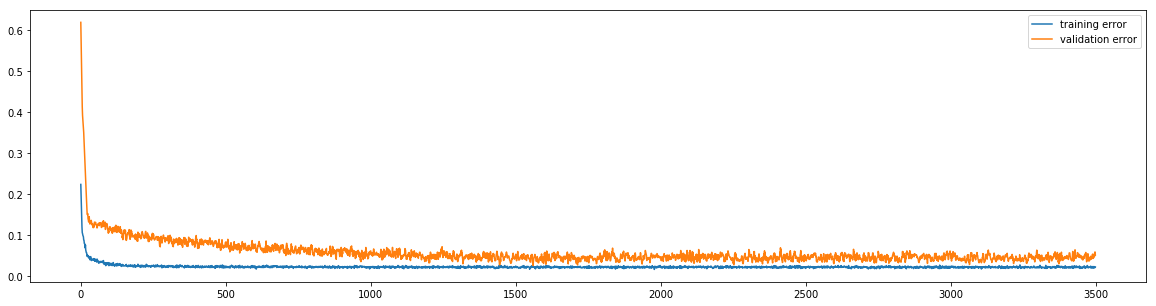

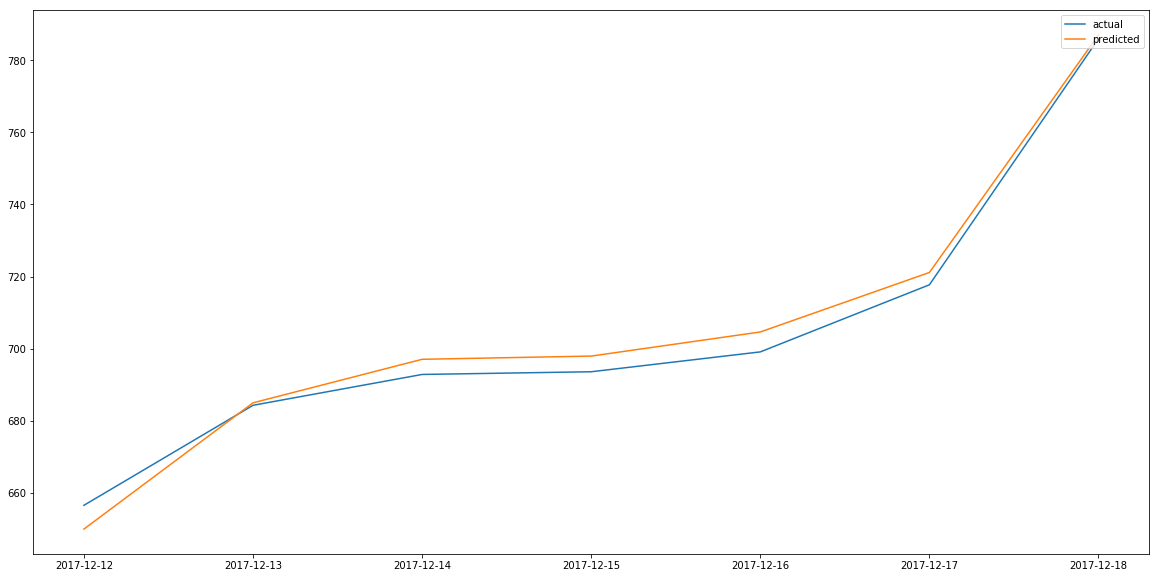

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [649.92, 684.96, 697.04, 697.93, 704.62, 721.13, 787.06]
differences: [6.61, 0.7, 4.21, 4.35, 5.53, 3.42, 1.07]
test RMSE: 4.211

Num Epochs: 4000


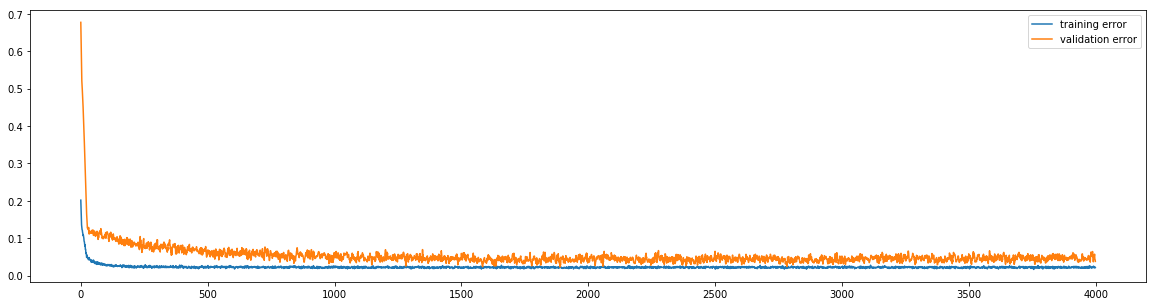

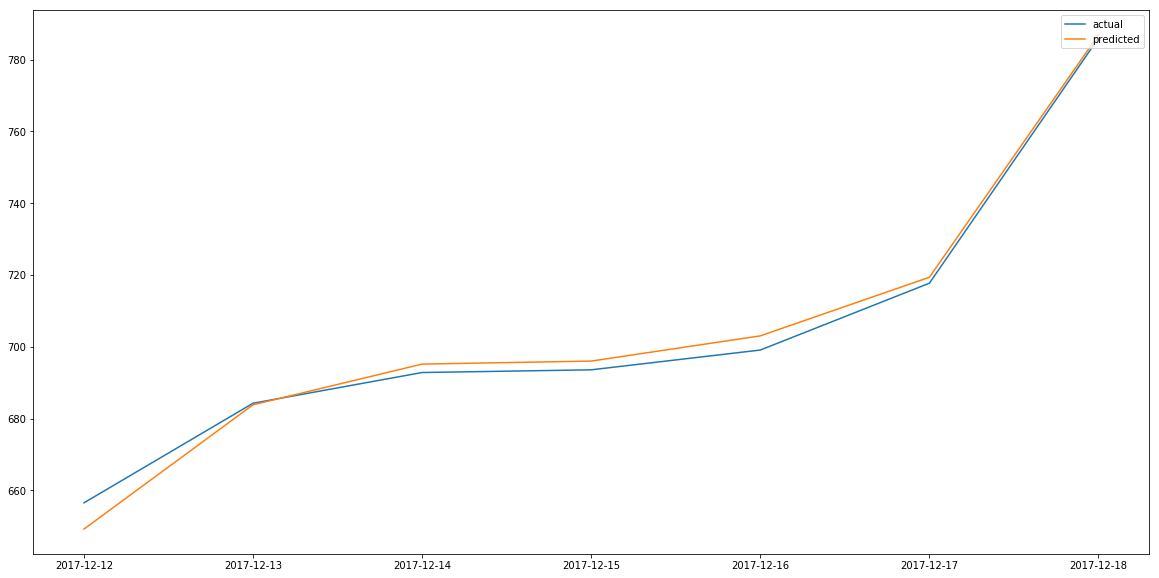

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [649.22, 683.85, 695.18, 696.02, 703.05, 719.37, 786.89]
differences: [7.3, 0.42, 2.35, 2.44, 3.96, 1.66, 0.9]
test RMSE: 3.468

Num Epochs: 4500


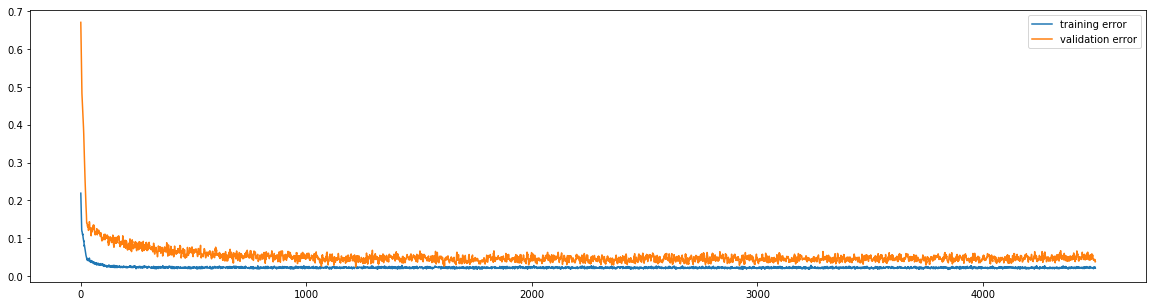

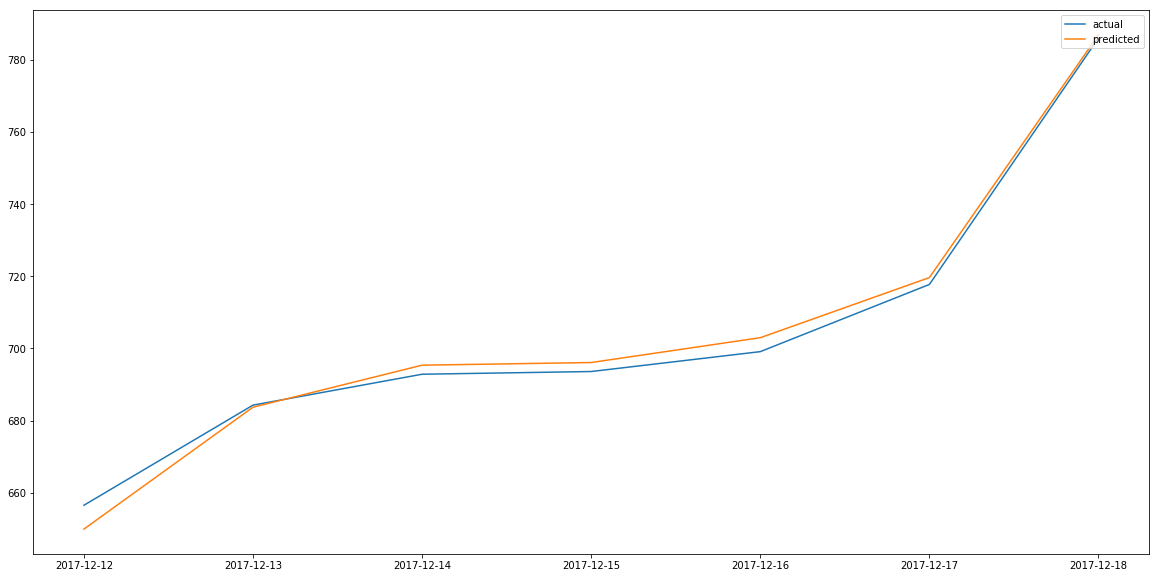

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [649.92, 683.7, 695.34, 696.08, 702.96, 719.62, 786.88]
differences: [6.61, 0.57, 2.51, 2.5, 3.88, 1.91, 0.89]
test RMSE: 3.292

Num Epochs: 5000


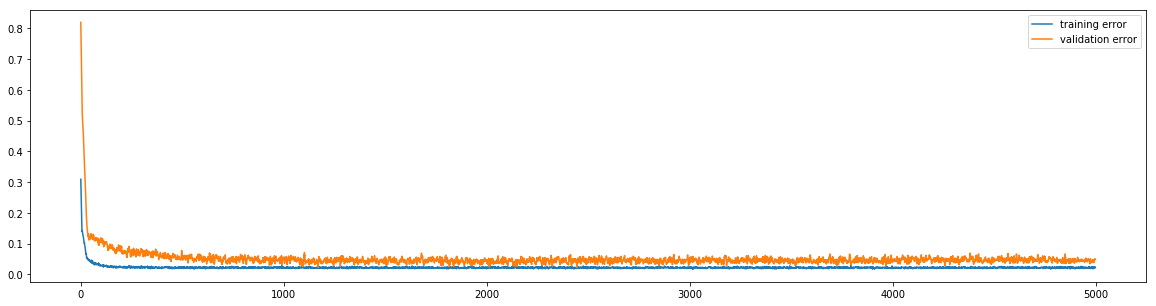

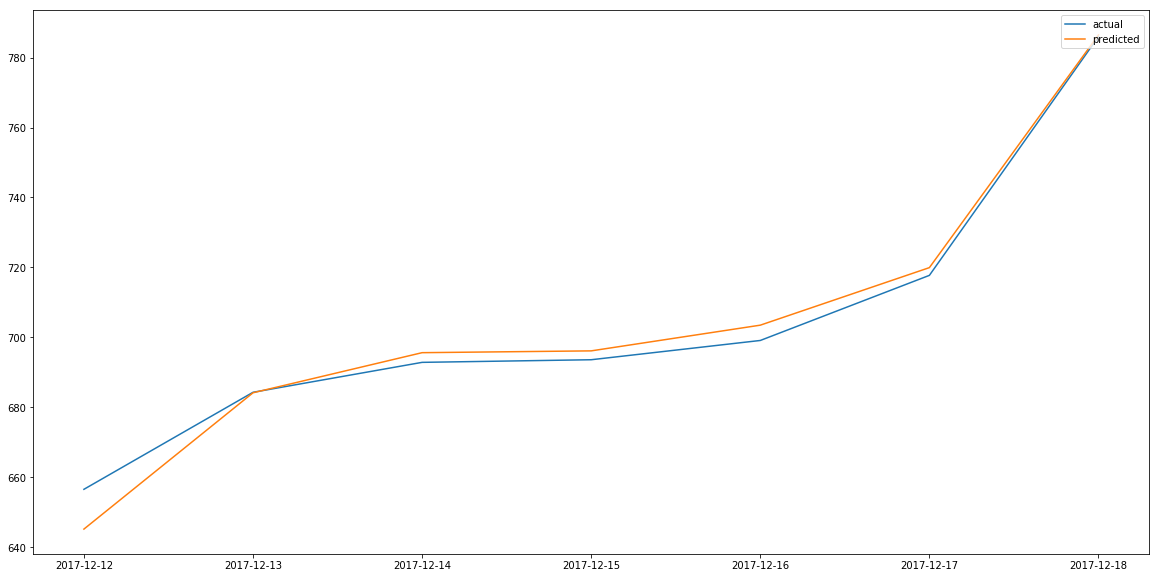

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [645.15, 684.13, 695.6, 696.12, 703.47, 719.93, 786.49]
differences: [11.38, 0.14, 2.77, 2.54, 4.38, 2.22, 0.5]
test RMSE: 4.896

Num Epochs: 5500


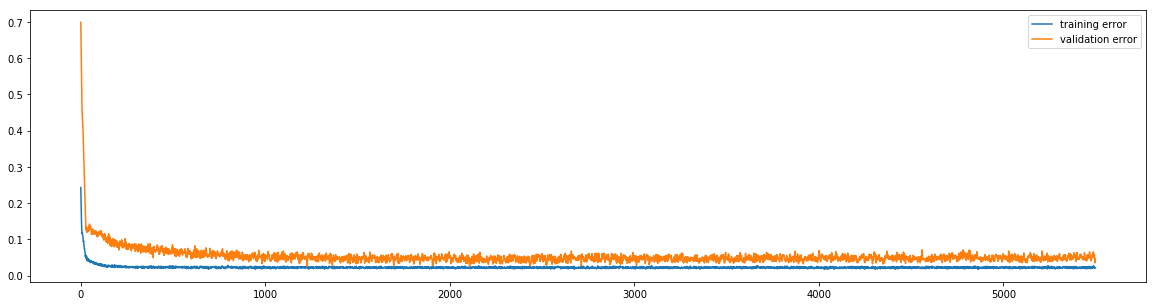

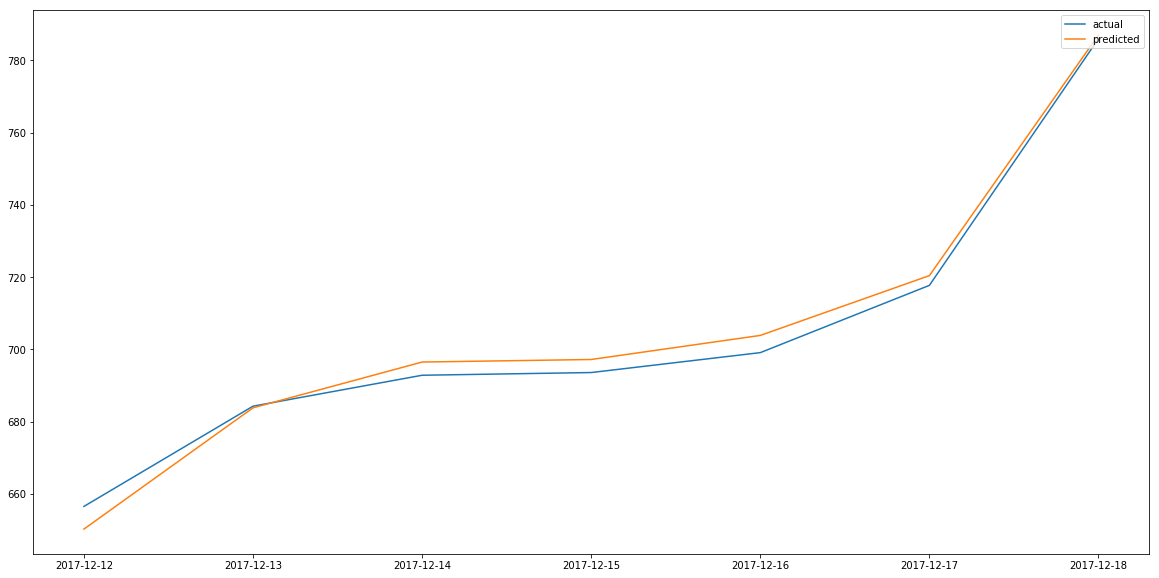

actual: [656.52, 684.27, 692.83, 693.58, 699.09, 717.71, 785.99]
predicted: [650.25, 683.82, 696.49, 697.2, 703.86, 720.41, 787.05]
differences: [6.27, 0.45, 3.66, 3.63, 4.77, 2.7, 1.06]
test RMSE: 3.726

Best Epoch Number is 4500
Best RMSE 3.2907574027919315


In [35]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
import matplotlib.pyplot as plt

def fit_lstm_model(train_X, train_y, test_X, test_y, RAW, SCALER, FEATURES, epochs, batch_size, alpha, dropout):
    TEST_SET_SIZE = len(test_y)
    TRAIN_SET_SIZE = len(ts) - TEST_SET_SIZE
    ALPHA = alpha # scaling factor for hidden layer neurons
    NUM_INPUT_LAYER_NEURONS = len(RAW.columns) # number of features
    NUM_OUTPUT_LAYER_NEURONS = 1 # features to predict
    HIDDEN_LAYER_NUM_NEURONS = int(TRAIN_SET_SIZE/(ALPHA * (NUM_INPUT_LAYER_NEURONS + NUM_OUTPUT_LAYER_NEURONS)))
    BATCH_SIZE = batch_size
    EPOCH_LIST = epochs
    
    # fit network and determine the optimal number of epochs according to lowest rmse
    lowest_rmse = 2^63 - 1
    best_epoch_num = EPOCH_LIST[0]

    print("Running LSTM on a list of epochs: ", EPOCH_LIST)
    for index, EPOCH in enumerate(EPOCH_LIST):
        # create the LSTM network
        model = Sequential()
        
        # Create a LSTM hidden layer that also specifies the input layer via the input_shape
        model.add(LSTM(HIDDEN_LAYER_NUM_NEURONS, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        
        history = model.fit(train_X, train_y, epochs=EPOCH, batch_size=BATCH_SIZE, 
                            validation_data=(test_X, test_y), verbose=0, shuffle=False)

        print("\nNum Epochs: " + str(EPOCH))

        # plot history
        plt.figure(figsize=(20, 5))
        plt.plot(history.history['loss'], label='training')
        plt.plot(history.history['val_loss'], label='testing')
        plt.legend(['training error', 'validation error'], loc='upper right')
        plt.show()

        # make a prediction
        model_output = model.predict(test_X)

        # reshape back to 2d
        test_X_2d = reshape_as_2d(test_X, FEATURES)
        test_y = pd.DataFrame(test_y)
        test_y.columns = ['Price']
    
        # invert scaling on forecast
        predictions = invert_minmax_scaling(test_X_2d, model_output, SCALER)

        # invert differencing on forecast
        inverted = list()
        for i in range(len(predictions)):
            value = invert_time_difference(RAW['Price'], predictions[i], len(predictions) - i + 1 )
            inverted.append(value)
            
        # calculate RMSE
        rmse = sqrt(mean_squared_error(RAW[-TEST_SET_SIZE:]['Price'], inverted))
        if rmse < lowest_rmse:
            lowest_rmse = rmse
            best_epoch_num = EPOCH

        plt.figure(figsize=(20, 10))

        LSTM_actual = RAW[-TEST_SET_SIZE:]['Price']
        LSTM_predicted = inverted
        
        # Plot actual vs predicted values
        plt.plot(LSTM_TS.index[-TEST_SET_SIZE:], LSTM_actual, label='actual')
        plt.plot(LSTM_TS.index[-TEST_SET_SIZE:], LSTM_predicted, label='predicted')
        plt.legend(['actual', 'predicted'], loc='upper right')
        plt.show()

        prediction_summary(LSTM_actual, LSTM_predicted)

    print("\nBest Epoch Number is " + str(best_epoch_num))
    print("Best RMSE " + str(lowest_rmse))
    
def run_lstm(ts, test_set_size, epochs, batch_size, alpha, dropout): 
    RAW = ts.copy(deep=True)
        
    FEATURES = ts.columns
    TEST_SET_SIZE = test_set_size
    
    # make ts stationary
    STATIONARY = difference_ts(ts)
    
    # Split time series data into training and testing sets
    STATIONARY_TRAIN, STATIONARY_TEST = train_test_split(STATIONARY, TEST_SET_SIZE)
        
    # Apply min max scaling to stationary data
    SCALED_STATIONARY_TRAIN, SCALED_STATIONARY_TEST, SCALER = apply_minmax_scaling(STATIONARY_TRAIN, STATIONARY_TEST, FEATURES)

    # split into input and outputs to feed into lstm
    train_X, train_y, test_X, test_y = input_output_split(SCALED_STATIONARY_TRAIN, SCALED_STATIONARY_TEST, 'Price')

    # copy test x and test y before converting test x and test y to 3d for lstm
    test_X_copy = test_X.copy(deep=True)
    test_y_copy = test_y.copy(deep=True)

    # reshape input to be 3D [samples, timesteps, features] for lstm model
    train_X = reshape_as_3d(train_X)
    test_X = reshape_as_3d(test_X)

    fit_lstm_model(train_X, train_y, test_X, test_y, RAW, SCALER, FEATURES, epochs, batch_size, alpha, dropout)
    
TEST_SET_SIZE = 7
EPOCHS = [3500, 4000, 4500, 5000, 5500]
BATCH_SIZE = 32
ALPHA = 2
DROPOUT_PERCENTAGE = 0.5
run_lstm(LSTM_TS, TEST_SET_SIZE, EPOCHS, BATCH_SIZE, ALPHA, DROPOUT_PERCENTAGE)

A good fit is a case where the performance of the model is good on both the train and validation sets. The train and validation loss should decrease and stabilize around the same point. The LSTM trained model returns losses that stabilize around the same point, so the model is a good fit.